
# Longitudinal Model: From measurements at the first visit and the time till the last visit we predict disease progression at the last visit

Disease progression is defined as worsening of diagnosis on the last visit compared to the the baseline diagnosis.

# 1 Data loading, preperation and cleaning

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")
sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.base import clone

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

In [2]:
adni_df = pd.read_csv("../data/ADNIMERGE.csv")
# print(adni_df.shape)
adni_df.head(3)

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,mPACCdigit,mPACCtrailsB,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.36665,NaN,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,CN,-4.35795,-4.15975,2005-09-08,0.0,10.67,18.67,5.0,28,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,-4.35795,-4.15975,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2018-11-08 22:51:22.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.08355,NaN,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,Dementia,-16.58450,-16.16580,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2018-11-08 22:51:22.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.05803,NaN,NaN,NaN,NaN,NaN,6.0,19.00,30.00,10.0,24.0,19.0,2.0,6.0,100.0000,NaN,19.0,135.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,31863.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,Dementia,-15.02030,-13.38660,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2018-11-08 22:51:22.0


In [3]:
adni1_df = adni_df[adni_df['ORIGPROT'] == 'ADNI1'].copy()
df = adni1_df.copy()
#print(df['DX_bl'].unique())
#print(df['DX'].unique())

In [4]:
#print('Before dropping: ' , df.shape)
df['DX'] = df['DX'].replace(to_replace='NONE', value=np.nan)
df=df.dropna(axis=0, subset=['DX'])
#print('After dropping: ' , df.shape)
#print(df['DX'].unique())

We are keeping only the last visit measurement since it contains all the measurements of the patient at the last visit plus baseline information. 

In [5]:
# Reducing the dataset to the last visit for every individual:
indexes_last_visit=[]
for patient_ids in df.PTID.unique():
  latest_visit_M=df[df.PTID==patient_ids]['M'].max()
  d=df[ df.PTID==patient_ids ]['M']== latest_visit_M
  ind=d.index[-1]
  indexes_last_visit.append(ind);
  
# Only last visits
df_last=df.loc[indexes_last_visit]

print("Before we had ", len(df), " rows.")
print("After we had  ", len(df_last), "  rows.")

Before we had  5059  rows.
After we had   819   rows.


In [6]:
diction_last_DX={}
for D in df_last['DX'].unique():
  diction_last_DX[D]=df_last[df_last['DX']==D]['M']/12
  
diction_first_DX={}
for D in df_last['DX_bl'].unique():
  diction_first_DX[D]=df_last[df_last['DX_bl']==D]['M']/12


When we stratify in groups based on the diagnosis of the first visit (left graph), we observe that:
 - People with AD at baseline only stayed 2.5 year at the most in our data set.
 - For Normal and MCI patients there were less obvious differences.

When we stratify in groups based on the diagnosis of the last visit (right graph), we observe that: 
 - All groups of diagnosis at the last visit have their last visits at similar times. No obvious difference between Dementia/Alzheimer and MCI or Normal diagnosed patients at the last visit.

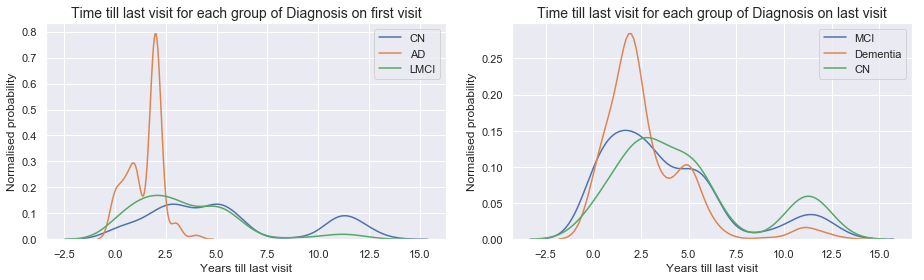

In [7]:
fig, axs= plt.subplots(1,2, figsize=(13,4))
ax=axs.ravel()
for key, val in diction_first_DX.items():
  sns.kdeplot(val, label=key, ax= ax[0])
  ax[0].set_title('Time till last visit for each group of Diagnosis on first visit')
  ax[0].set_xlabel('Years till last visit')
  ax[0].set_ylabel('Normalised probability')
  ax[0].legend()
for key, val in diction_last_DX.items():
  sns.kdeplot(val, label=key, ax= ax[1])
  ax[1].set_title('Time till last visit for each group of Diagnosis on last visit')
  ax[1].set_xlabel('Years till last visit')
  ax[1].set_ylabel('Normalised probability')
  ax[1].legend()
plt.tight_layout()

As a second step we remove all the information of the last visit, except the time till the last visit and the diagnosis at the last visit.

- Dropping meaningless and duplicate features 
- Keep all features of baseline visit
- Drop all features of the last visit measurements except time till last visit and diagnosis
- Imputation of missing values by 5 KNN
- Scaling between 0 and 1

In [8]:
df=df_last
df.head()

# dealing with the '<' and '>' in abeta and tau and ptau
genes = ['TAU_bl', 'ABETA_bl', 'PTAU_bl']
for val in genes:
    all_vals = df[val].values
    df = df.drop(val, axis=1)
    df[val] = [float(str(x).replace('<','').replace('>','')) for x in all_vals]

# drop collinear, unrelated or missing variables
collinear = ['VISCODE', 'update_stamp', 'Month', 'Month_bl', 'Years_bl']
unrelated = ['RID', 'PTID', 'SITE', 'ORIGPROT', 'COLPROT', 'FSVERSION','FSVERSION_bl', 'IMAGEUID', 'FLDSTRENG','FLDSTRENG_bl', 'EXAMDATE' ,  'EXAMDATE_bl']
baselines = []
nulls = dict(df.isna().sum().sort_values())
null_cols = []
drop_non_bl=['FDG', 'PIB', 'AV45', 'ABETA',
             'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
             'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
             'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR',
             'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat',
             'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal',
             'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
             'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG',
             'FSVERSION', 'IMAGEUID', 'Ventricles', 'Hippocampus', 'WholeBrain',
             'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'mPACCdigit',
             'mPACCtrailsB']

empty=['MOCA_bl', 'EcogSPTotal_bl', 'EcogPtVisspat_bl', 'EcogPtPlan_bl','EcogPtOrgan_bl','EcogPtDivatt_bl',
       'EcogPtTotal_bl','EcogSPMem_bl','EcogSPLang_bl','EcogSPVisspat_bl',
       'EcogSPPlan_bl','EcogSPOrgan_bl','EcogSPDivatt_bl', 'AV45_bl', 'EcogPtMem_bl', 'EcogPtLang_bl'] 

# filling out null_cols and baselines
for i in df.columns.values:
    if '_bl' in i or '_BL' in i:
        baselines.append(i)
    elif nulls[i] > df.shape[0]/1.1:
        baselines.append(i)
        
df = df.drop(collinear + unrelated + null_cols + drop_non_bl + empty, axis=1)

# dealing with categorical variables
df['PTGENDER'] = (df['PTGENDER'] == 'Female')*1

categoricals = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
dummies = pd.get_dummies(df[categoricals])
df = pd.concat([df, dummies], axis=1)

# more informative names
df = df.rename(index=str, columns={"PTGENDER": "PTGENDER_Female"})

# drop categoricals
df = df.drop(categoricals, axis=1)

# making the 'DX' variable numeric
df['DX'] = df['DX'].map({'CN': 1, 'MCI': 2, 'Dementia': 3})
df['DX_bl'] = df['DX_bl'].map({'CN': 1, 'LMCI': 2, 'AD': 3})

# dropping rows that are missing the response variable
df = df.dropna(subset=['DX'])
df = df.dropna(subset=['DX_bl'])



In [9]:
# imputation through kNN with 5 neighbors

null_df = pd.DataFrame(df.isna().sum().sort_values(), columns=['Nulls'])
new_nulls = null_df[null_df['Nulls'] > 0].to_dict()['Nulls']
nulls = new_nulls.keys()
not_nulls = df.columns.difference(nulls).values
ind_dict = {}

# filling it with a weird value for now
weird_value = -247
df = df.fillna(weird_value)

for n, col in enumerate(nulls):
  # Training set: all the rows for which the entry in the corresponding column does not contain a '0'
  pseudo_train = df[df[col] != weird_value]
  pseudo_x = pseudo_train[pseudo_train.columns.difference([col, 'DX'])]
  pseudo_y = pseudo_train[col]

  # Doing the same for the "test" set
  pseudo_test = df[df[col] == weird_value]
  pseudo_x_tes = pseudo_test[pseudo_test.columns.difference([col, 'DX'])]
  pseudo_y_tes = pseudo_test[col]

  # Fitting a kNN model with N=5
  chosen_model = KNeighborsRegressor(n_neighbors=5).fit(pseudo_x, pseudo_y)

  # Saving the indices into a dictionary
  ind = df[df[col] == weird_value][col].index.values
  ind_dict[col] = chosen_model.predict(pseudo_x_tes)
    
# doing the actual imputation
for col in nulls:
  ind = df[df[col] == weird_value][col].index.values
  df.loc[ind, col] = ind_dict[col]

# 2 Base Logistic Regression Model

We are splitting in a training set (80%) and test set (20%).

In [10]:
# Train-test split for two different models: 
# Splitting in two different cases:
df_1 = df[df['DX_bl']==1]  # Patients with normal diagnosis at baseline
df_2 = df[df['DX_bl']==2]  # Patients with MCI diagnosis at baseline

y_1 = ( df_1['DX'] > df_1['DX_bl'] ) # if Dx went from 1 (Dx_bl )to 2/3 (Dx) -> y =1  if DX did change y=0
X_1 = df_1[df_1.columns.difference(['DX'])]

y_2 = ( df_2['DX'] > df_2['DX_bl'] ) # if Dx went from 2 (Dx_bl )to 3 (Dx) -> y =1  otherwhise y=0
X_2 = df_2[df_2.columns.difference(['DX'])]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.2, random_state=209)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, random_state=209)

# print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
# print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)

## 2.1 Basic Naive Logistic model only taking into account time till last visit

Left graph: Disease progression from **normal Baseline to MCI/AD progression on last visit**
 - We observe more disease progression from normal to MCI or AD when the last visit occurs later. 
Right graph: Disease progression from **MCI at baseline to AD at the last visit**
 - For MCI to AD disease progression we see no real difference in distribution of people with disease progression and people without disease when we only look at the variable of when the last visit occurs. The time till last visit will be far less important or non-predictive in our predictive model to model change from MCI baseline to AD at last visit.

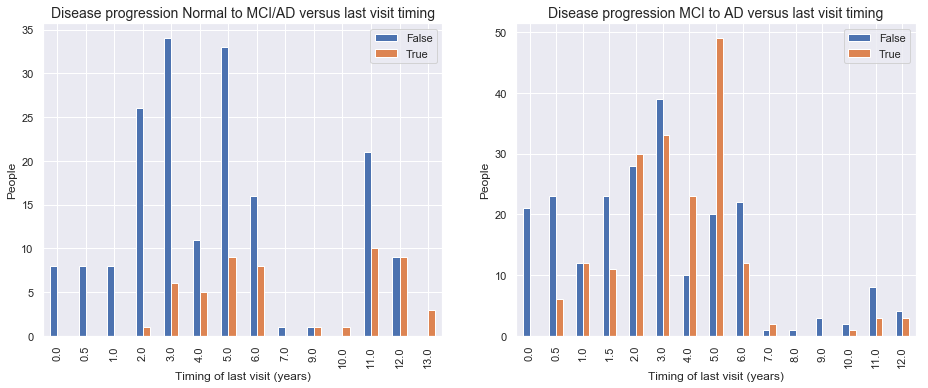

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5.5))
ax1, ax2 = ax.ravel()

pd.crosstab(X_1['M']/12,y_1).plot(kind='bar', ax=ax1)
ax1.set_title('Disease progression Normal to MCI/AD versus last visit timing')
ax1.set_xlabel('Timing of last visit (years)')
ax1.set_ylabel('People')
ax1.legend()

pd.crosstab(X_2['M']/12,y_2).plot(kind='bar', ax=ax2)
ax2.set_title('Disease progression MCI to AD versus last visit timing')
ax2.set_xlabel('Timing of last visit (years)')
ax2.set_ylabel('People')
ax2.legend()

fig.tight_layout()

In [12]:
# Code credit: sklearn adapted very handy to plot confusion matrices.
def plot_confusion_matrix(ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm_original=cm.copy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(img, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set(xticks=tick_marks, yticks=tick_marks)
    ax.set_xticklabels(classes, rotation=0, fontsize=13)
    ax.set_yticklabels(classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    thresh = 1 / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j]*100, '.0f') +  '%  (' +format(cm_original[i, j], 'd') + ')',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=15)

    ax.set_title(title, fontsize=15)
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)
    ax.grid('off')

### 2.1.1 Logistic Regression Disease progression model for baseline normal patients based only on time till last visit

**The following confusion matrix**: Modeling the disease progression from **normal Baseline progressing to MCI/AD at last visit** only based on time till last visit.


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit.

Training accuracy: 	0.80 
Test accuracy: 		0.63



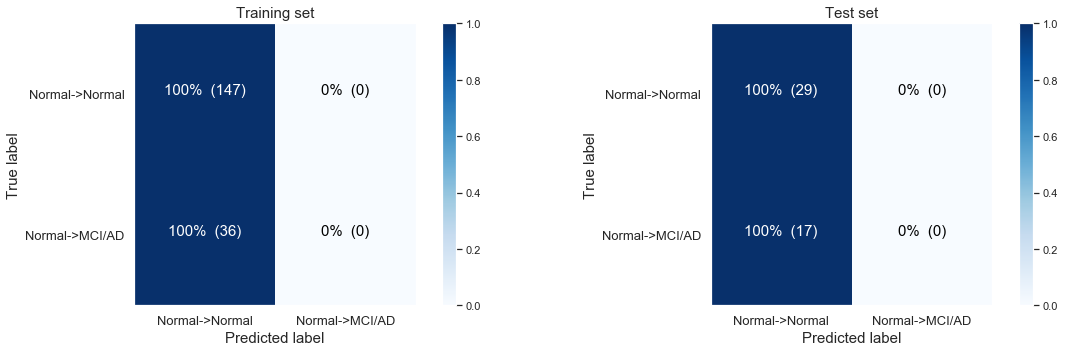

In [13]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear').fit(X_train1['M'].values.reshape(-1,1), y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit.')

print('\nTraining accuracy: \t{:.2f} \nTest accuracy: \t\t{:.2f}\n'.format(baseline_logreg_1.score(X_train1['M'].values.reshape(-1,1), y_train1), baseline_logreg_1.score(X_test1['M'].values.reshape(-1,1), y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1['M'].values.reshape(-1,1)))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

We observe that the model is not predicting anything at all! The most likely case is for people to stay stabile and to show no disease progression at the last visit: 
- 147 stabile patients in our training set, 29 in our test set
- 36 with disease progression in our training set, , 17 in our test set. 

If we don't balance for the unequal classes we end up in our very basic logistic regression model always "predicting" a person will stay stabile. Here we are still only using the 'time till the last visit' as our single variable.

**The following confusion matrix**: We get a better model when we **balance the unequal size groups** (by the parameter ```class_weight='balanced'``` in our ```LogisticRegression()``` object. Here we see we are now able to predict the people that are showing disease progression, yet of the cost of more false positives and with low discrimitive power.


Simple logistic regression modeling with the CLASS WEIGHTS  BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit

Training accuracy: 	0.70 , 
Test accuracy: 		0.70



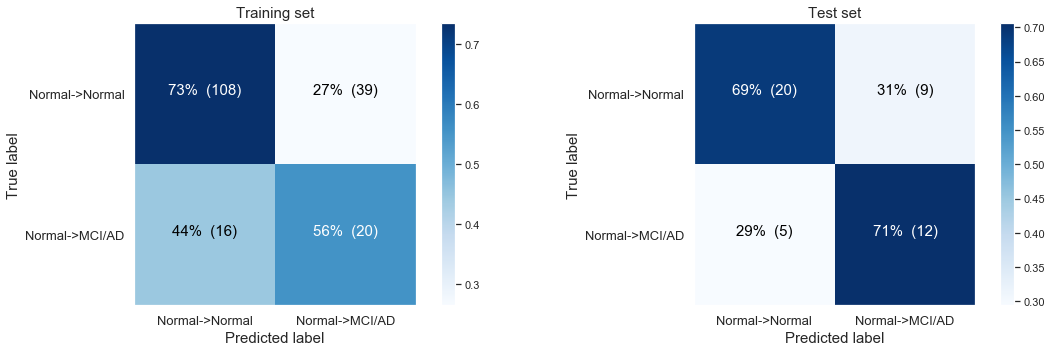

In [14]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS  BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1['M'].values.reshape(-1,1), y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('\nTraining accuracy: \t{:.2f} , \nTest accuracy: \t\t{:.2f}\n'.format(baseline_logreg_1.score(X_train1['M'].values.reshape(-1,1), y_train1), baseline_logreg_1.score(X_test1['M'].values.reshape(-1,1), y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1['M'].values.reshape(-1,1)))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

The **balancing of the unequal size groups** by the parameter ```class_weight='balanced'``` did increase our test accuracy from 0.63 to 0.70.

### 2.1.2  Logistic Regression Disease progression model for baseline MCI patients based only on time till last visit

**The following confusion matrix**: Modelling non-balanced, **MCI Baseline, progressing to AD at last visit** only based on time till last visit.


Simple logistic regression modeling with the CLASS WEIGHTS NON BALANCED

Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit

Training accuracy: 	0.58 , 
Test accuracy: 		0.49



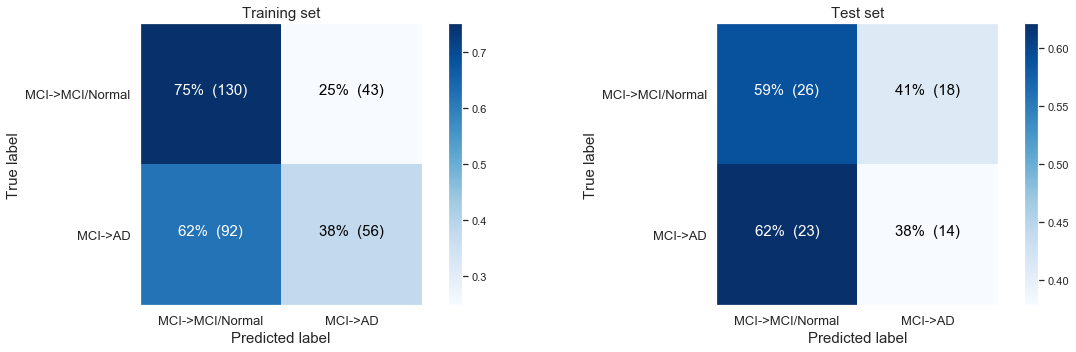

In [15]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS NON BALANCED')
baseline_logreg_2 = LogisticRegression(solver='liblinear').fit(X_train2['M'].values.reshape(-1,1), y_train2)
print('\nLogistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
print('\nTraining accuracy: \t{:.2f} , \nTest accuracy: \t\t{:.2f}\n'.format(baseline_logreg_2.score(X_train2['M'].values.reshape(-1,1), y_train2), baseline_logreg_2.score(X_test2['M'].values.reshape(-1,1), y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr2 = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2['M'].values.reshape(-1,1)))
cnf_matrix_ts2 = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Test set')
fig.tight_layout()

As expected from the first barchart in 2.1.: For MCI to AD disease progression we saw no real difference in distribution of people with disease progression and people without disease when we looked at the variable of when the last visit occurs. The time till last visit will be far less important or non-predictive in our predictive model to model change from MCI baseline to AD at last visit. Here we observe a test accuracy of 0.49, so indeed a very bad performance.


**The following confusion matrix**: Modelling balanced, MCI Baseline, progressing to AD only based on time till last visit, yet now again with balanced class.


Simple logistic regression modeling with the CLASS WEIGHTS BALANCED

Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit

Training accuracy: 	0.61 
Test accuracy: 		0.54



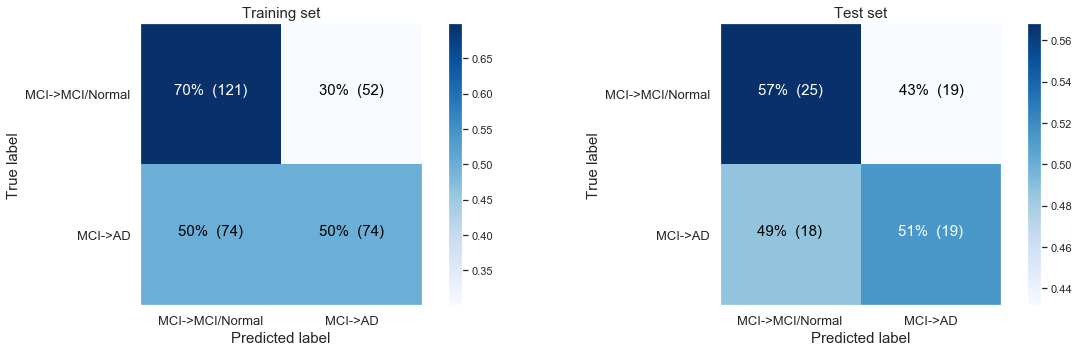

In [16]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS BALANCED')
baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2['M'].values.reshape(-1,1), y_train2)
print('\nLogistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
print('\nTraining accuracy: \t{:.2f} \nTest accuracy: \t\t{:.2f}\n'.format(baseline_logreg_2.score(X_train2['M'].values.reshape(-1,1), y_train2), baseline_logreg_2.score(X_test2['M'].values.reshape(-1,1), y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr2 = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2['M'].values.reshape(-1,1)))
cnf_matrix_ts2 = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2['M'].values.reshape(-1,1)))
plot_confusion_matrix(ax1, cnf_matrix_tr2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts2, classes=['MCI->MCI/Normal','MCI->AD'], normalize=True, title='Test set')
fig.tight_layout()

We can plot the logistic regression model by looking at the probabilit of disease progression versus the time of our last visit. Our non-balanced model was not good, yet in our balanced model we observed a big improvement of our normal baseline to MCI/AD progression model. Here we can observe this also by an increased slope for the balanced model for predicting normal baseline to MCI/AD progression model (right graph, blue line). 

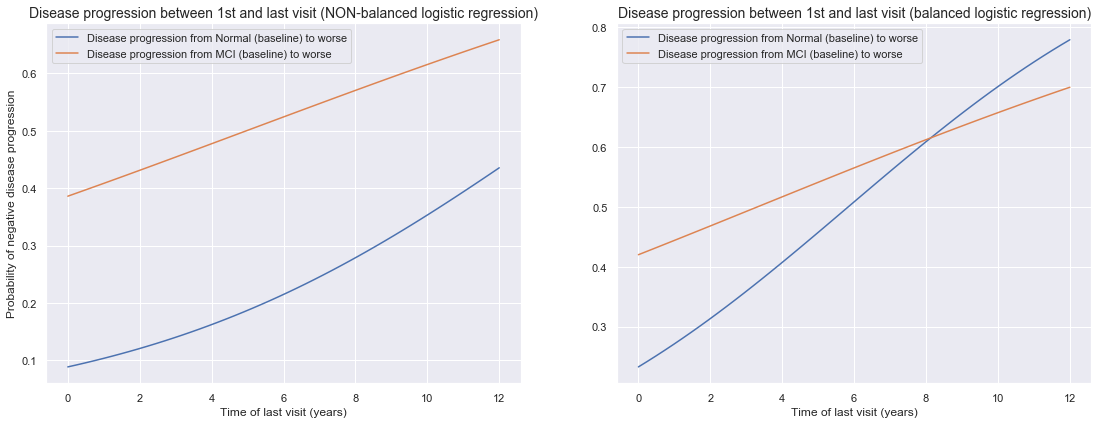

In [17]:
# Plotting regression line of non balanced logistic regression versus age
baseline_logreg_1 = LogisticRegression(solver='liblinear').fit(X_train1['M'].values.reshape(-1,1), y_train1)
baseline_logreg_2 = LogisticRegression(solver='liblinear').fit(X_train2['M'].values.reshape(-1,1), y_train2)

Months= np.linspace(start=0, stop=12*12, num=50)
pred1= baseline_logreg_1.predict_proba(Months.reshape(-1,1))[:,1]
pred2= baseline_logreg_2.predict_proba(Months.reshape(-1,1))[:,1]

fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].plot(Months/12, pred1, label='Disease progression from Normal (baseline) to worse')
ax[0].plot(Months/12, pred2, label='Disease progression from MCI (baseline) to worse')
ax[0].legend()
ax[0].set_title('Disease progression between 1st and last visit (NON-balanced logistic regression)')
ax[0].set_xlabel('Time of last visit (years)')
ax[0].set_ylabel('Probability of negative disease progression');

# Plotting regression line of non balanced logistic regression versus age
baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1['M'].values.reshape(-1,1), y_train1)
baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2['M'].values.reshape(-1,1), y_train2)

Months= np.linspace(start=0, stop=12*12, num=50)
pred1= baseline_logreg_1.predict_proba(Months.reshape(-1,1))[:,1]
pred2= baseline_logreg_2.predict_proba(Months.reshape(-1,1))[:,1]

ax[1].plot(Months/12, pred1, label='Disease progression from Normal (baseline) to worse')
ax[1].plot(Months/12, pred2, label='Disease progression from MCI (baseline) to worse')
ax[1].legend()
ax[1].set_title('Disease progression between 1st and last visit (balanced logistic regression)')
ax[1].set_xlabel('Time of last visit (years)')
ax[1].set_label('Probability of negative disease progression');
plt.tight_layout()

## 2.2 Logistic model  taking into account all baseline measurements and time till last visit

### 2.2.1 Modelling Normal Baseline patients progressing to MCI/AD taking into account all baseline measurements and time till last visit 
- Balanced for the unequal classes


Simple logistic regression modeling with the CLASS WEIGHTS BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit

Training accuracy: 	0.75
Test accuracy: 		0.63



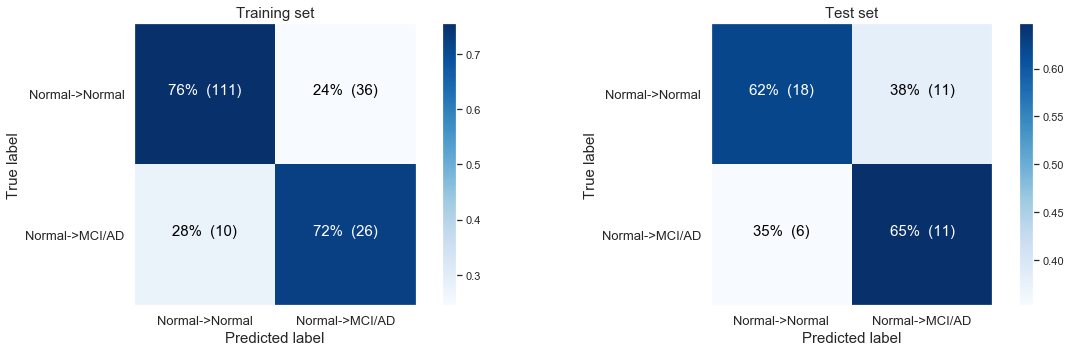

In [18]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS BALANCED')

baseline_logreg_1 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train1.values, y_train1)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('\nTraining accuracy: \t{:.2f}\nTest accuracy: \t\t{:.2f}\n'.format(baseline_logreg_1.score(X_train1.values, y_train1), baseline_logreg_1.score(X_test1.values, y_test1)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train1 , baseline_logreg_1.predict(X_train1.values))
cnf_matrix_ts = confusion_matrix(y_test1 , baseline_logreg_1.predict(X_test1.values))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

Most important features are the ADAS (Alzheimers Disease Assessment Scale) results, patient educaiton and FAQ_bl (Functinoal Activities Questionnaire score at baseline).


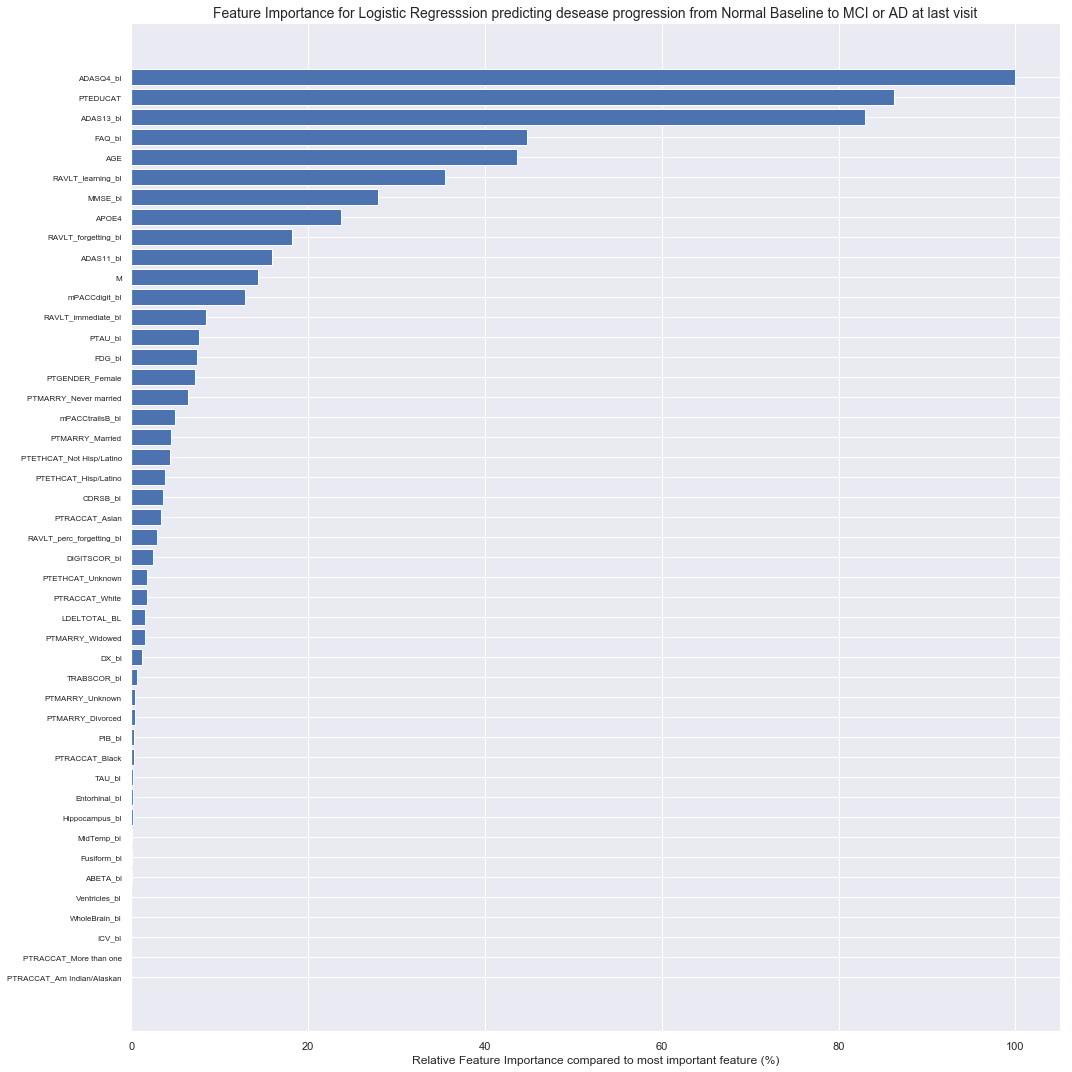

In [19]:
print('Most important features are the ADAS (Alzheimers Disease Assessment Scale) results, patient educaiton and FAQ_bl (Functinoal Activities Questionnaire score at baseline).')

# Feature importance analysis, sort and visualization (for normal baseline model)
feature_importance = abs(baseline_logreg_1.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(15,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train1.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance compared to most important feature (%)')
featax.set_title('Feature Importance for Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')

plt.tight_layout()   
plt.show()

### 2.2.1 Modelling MCI Baseline patients progressing to AD taking into account all baseline measurements and time till last visit
- Balanced for the unequal classes


Simple logistic regression modeling with the CLASS WEIGHTS BALANCED

Logistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit
Training accuracy: 	0.76 , Test accuracy: 		0.63



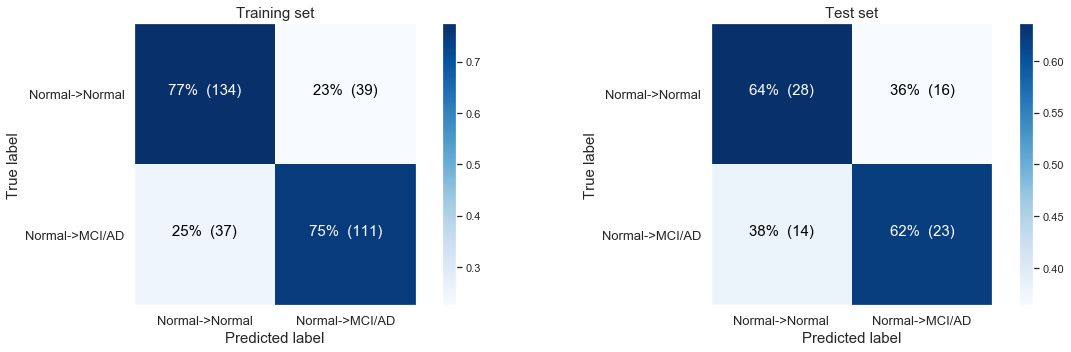

In [20]:
print('\nSimple logistic regression modeling with the CLASS WEIGHTS BALANCED')

baseline_logreg_2 = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train2.values, y_train2)
print('\nLogistic Regresssion predicting desease progression from Normal Baseline to MCI or AD at last visit')
print('Training accuracy: \t{:.2f} , Test accuracy: \t\t{:.2f}\n'.format(baseline_logreg_2.score(X_train2.values, y_train2), baseline_logreg_2.score(X_test2.values, y_test2)))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5,5))
ax1, ax2 = ax.ravel()
cnf_matrix_tr = confusion_matrix(y_train2 , baseline_logreg_2.predict(X_train2.values))
cnf_matrix_ts = confusion_matrix(y_test2 , baseline_logreg_2.predict(X_test2.values))
plot_confusion_matrix(ax1, cnf_matrix_tr, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Training set')
plot_confusion_matrix(ax2, cnf_matrix_ts, classes=['Normal->Normal','Normal->MCI/AD'], normalize=True, title='Test set')
fig.tight_layout()

Most important features:
1. M 		: Months after baseline
2. CDRSB_bl 	: Clinical Dementia Rating–Sum of Boxes at baseline.
3. FAQ_bl 	: Functinoal Activities Questionnaire score at baseline



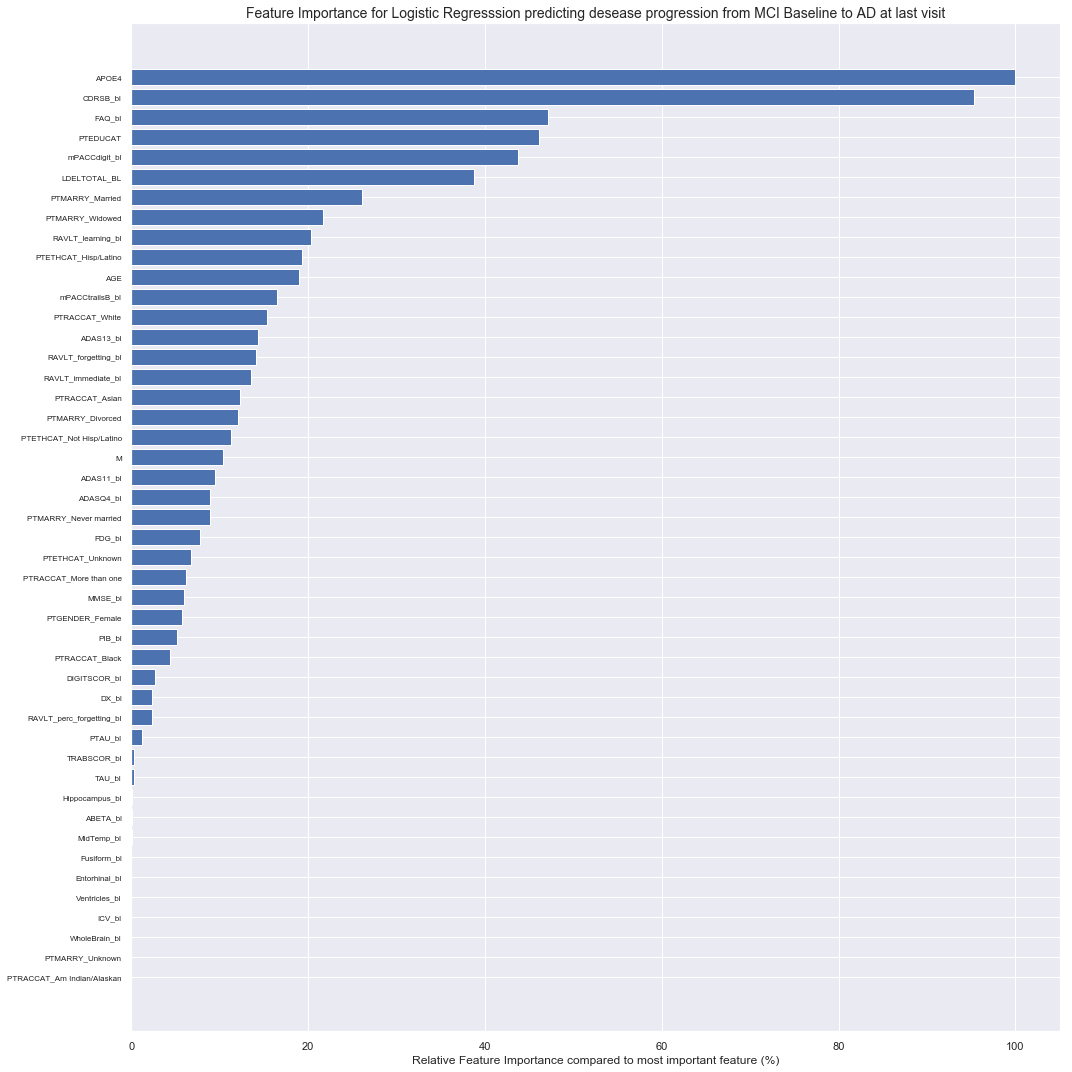

In [21]:
# Feature importance analysis, sort and visualization (for MCI baseline model)
print('Most important features:')
print('1. M \t\t: Months after baseline')
print('2. CDRSB_bl \t: Clinical Dementia Rating–Sum of Boxes at baseline.')
print('3. FAQ_bl \t: Functinoal Activities Questionnaire score at baseline\n')

feature_importance = abs(baseline_logreg_2.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(15,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train2.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance compared to most important feature (%)')
featax.set_title('Feature Importance for Logistic Regresssion predicting desease progression from MCI Baseline to AD at last visit')
plt.tight_layout()   

# 3 Advanced Model Testing with Cross Validation score reporting and CV parameter optimization within training fold

### 3.1 Parameter Optimisation and Cross Validation

- Parameters were optimised by a grid search on specific parameter values using a 3-fold cross-validation on the 75 percent training cohort to determine which parameter values led to the best performance. 
- For quantification of this 3-fold cross-validation (CV) the accuracy was used as the scoring function. 
- After this three-fold CV, the best set of parameters was used to train a model on the full 75% training set, and this model was validated on the remaining 25% percent test cohort.
- At the end we present the average and standard deviation of the accuracy, precision, recall, sensitivity, AUROC etc. of these 4 outer Cross Validations.

**Cross-validation setting:** 
- 4-fold cross validation ( so averages on these 4 test sets will be reported )
- Within every training fold of cross validation we do an internal 3-fold CV to optimise the parameters

**How do we asses the performance of our models, what is our scoring function?**

The performance of machine-learning models, was quantified by 4-fold cross-validation as mentioned before. Each of 4 folds produced a machine learning model trained on 75 percent of the dataset and was validated on the remaining 25 percent of the dataset. This resulted in a final independent validation prediction for every single subject of the cohort based on a independent training set of 75 percent of the dataset not including the specific subject itself.


Two performance measurements were used specifically that allowed us to evaluate the predictions **in a threshold independent manner**. This is important since this is how we can avoid the problem of having to set a threshold or to balance our initial groups to prevent our model from always predicting the same outcome for all (the outcome of the largest group of our training set).

- **Area Under the Receiver Operating Characteristic curve (AUROC)** as defined by Scikit-learn’s ```roc_auc_score()```.
- **Average Precision-Recall (APR)** as defined by Scikit-learn’s ```average_precision_score()```. Average Precision-Recall summarizes the precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight [1]. The APR is approximately AUROC multiplied by the initial precision of the system [2]. For each model AUROC and APR was reported as well as the absolute difference with baseline risk prediction (American ACC/AHA ASCDV or European SCORE risk estimation).
 
[1] Zhu M. Recall, precision and average precision. Working Paper 2004-09, Department of Statistics & Actuarial Science University of Waterloo 2004; :1–11.

[2] Su W, Yuan Y, Zhu M. A Relationship between the Average Precision and the Area Under the ROC Curve. Proceedings of the 2015 International Conference on The Theory of Information Retrieval 2015; :349–52. doi: 10.1145/2808194.2809481

**Illustrated example of Parameter Optimization:**

Model: ```LogisticRegression(random_state = 1, solver = 'liblinear', class_weight = 'balanced')```

Tested Estimator_parameters ``à 'C': [0.1, 100]```

In [22]:
X_CV=X_1
y_CV=y_1

In [23]:
Estimator_parameters = {'C':[0.1,1,10,100] }
Estimator=LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')

Here below we see a print of all the 4 Cross validations, the accuracy scores with also the best set of paremeters in this run. We see that with every CV run we add a value of the outer validation accuaracy to the last list that is printed.

In [24]:
import time
start = time.time()

# All 10 parameter optimisations and cross validations of a certain Classifier
# Split the data randomly (stratified) in 10 folds
splits = 4
print("All {} PARAMETER OPTIMISATIONS AND CROSS VALIDATIONS OF THE \"LogisticRegression()\" ALGORITHM".format(splits))
strat_kfold_external = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
splitted_indexes_external = strat_kfold_external.split(X_CV, y_CV)

params= [len(Estimator_parameters[param]) for param in Estimator_parameters]
total_params= np.prod(params)

best_index=[]
Sum=[0]*total_params
AP_Score =np.array([])
ROC_Score =np.array([])
Prec_Score =np.array([])
Recall_Score =np.array([])
F1_Score =np.array([])
Sens_Score =np.array([])
Spec_Score =np.array([])
Accuracy_Score =np.array([])

best_predictions_all=np.array([])
test_all=np.array([])
i=0
for train_index_external, test_index_external in splitted_indexes_external:
    i+=1
    print("\nThis is optimisation and CV number {}  \t----------------------------------------------------------------------------".format(i))
    
    # take i’th fold as test set and the other 3 folds together as training set
    X_train, X_test = X_CV.iloc[train_index_external], X_CV.iloc[test_index_external]
    y_train, y_test = y_CV.iloc[train_index_external], y_CV.iloc[test_index_external]    
    # take the training set and split it randomly (stratified) 
    # in an inner training set of 2/3 size and an inner validation set of 1/3 size
        
    # for each of the ML methods
    # for each combination of parameter values
    # train the ML method with specified parameters on inner training set and validate on inner validation set
    # take the combination of parameter values that yields highest performance (e.g. area under PR curve), 
    # also write down this parameter value combination train the ML method with best parameter values on
    # the (outer) training set and test on the (outer) test set
                
    mod=clone(Estimator)
    optimisation_param_AP = GridSearchCV(estimator=mod, param_grid=Estimator_parameters, cv=3, verbose=0, scoring='roc_auc')
    optimisation_param_AP.fit(X_train, y_train)
    print('Mean scores: \t\t\t\t{}'.format((optimisation_param_AP.cv_results_['mean_test_score']).round(4)))
    print('Differences best - other scores:\t{}'.format((optimisation_param_AP.best_score_-optimisation_param_AP.cv_results_['mean_test_score']).round(4)))
    print('The best paremeters set was\t \tSet {}: {}'.format(optimisation_param_AP.best_index_ +1, optimisation_param_AP.best_params_))
    best_index.append(optimisation_param_AP.best_index_+1)
    # Building Random Forest Estimator with best parameters
    best= optimisation_param_AP.best_estimator_
    best.fit(X_train, y_train)
    best_predictions = best.predict_proba(X_test)[:,1]
    best_predictions=best_predictions
    Average_precision_score=average_precision_score(y_test, best_predictions)
    best_predictions_binary =  best.predict(X_test)
    t=confusion_matrix(y_test, best_predictions_binary)
    sensitivity=(t[1][1]/(t[1][0]+t[1][1]))
    specificity=(t[0][0]/(t[0][1]+t[0][0]))
    AP_Score =np.append(AP_Score , Average_precision_score)
    ROC_Score =np.append(ROC_Score , roc_auc_score(y_test, best_predictions))
    Prec_Score =np.append(Prec_Score , precision_score(y_test, best_predictions_binary))
    Recall_Score =np.append(Recall_Score , recall_score(y_test, best_predictions_binary))
    F1_Score =np.append(F1_Score , f1_score(y_test, best_predictions_binary))
    Sens_Score =np.append(Sens_Score , sensitivity)
    Spec_Score =np.append(Spec_Score , specificity)
    Accuracy_Score =np.append(Accuracy_Score , accuracy_score(y_test, best_predictions_binary))
    Sum=Sum+(optimisation_param_AP.cv_results_['mean_test_score']).round(2)
   
    best_predictions_all=np.append(best_predictions_all,best_predictions)
    test_all=np.append(test_all,y_test)
    print('Validation AUROC score: \t\t{}'.format(ROC_Score .round(2)))
    

end = time.time()
print('\n\nElapsed time: ', round(end - start, 2),'seconds.' )

All 4 PARAMETER OPTIMISATIONS AND CROSS VALIDATIONS OF THE "LogisticRegression()" ALGORITHM

This is optimisation and CV number 1  	----------------------------------------------------------------------------
Mean scores: 				[0.729  0.6981 0.6993 0.6894]
Differences best - other scores:	[0.     0.0309 0.0297 0.0396]
The best paremeters set was	 	Set 1: {'C': 0.1}
Validation AUROC score: 		[0.7]

This is optimisation and CV number 2  	----------------------------------------------------------------------------
Mean scores: 				[0.6746 0.6453 0.6724 0.6418]
Differences best - other scores:	[0.     0.0293 0.0022 0.0328]
The best paremeters set was	 	Set 1: {'C': 0.1}
Validation AUROC score: 		[0.7 0.8]

This is optimisation and CV number 3  	----------------------------------------------------------------------------
Mean scores: 				[0.7271 0.7117 0.7052 0.7052]
Differences best - other scores:	[0.     0.0154 0.0218 0.0219]
The best paremeters set was	 	Set 1: {'C': 0.1}
Validation AURO

We can summarize the performance of every parameter set by averaging all 4 validation scores. Looking at which set gave us the highest average score indicates the best parameter setting.

In [25]:
print("Parameter tested: ", Estimator_parameters)
Avg=Sum/splits
print('\nAverage of {} splits mean_test_score for all 4 parameter sets:\n{}'.format(splits, Avg.round(4)))
print('Differences best Average - Average for all 4 parameter sets:\n{}'.format((Avg.max()-Avg).round(4)))
print('\nBest Average mean_test_score = {} for the {}th parameter: {}'.format(round(Avg.max(),2), Avg.argmax()+1, optimisation_param_AP.cv_results_['params'][Avg.argmax()]))
print('Index of the Best Parameter Set for all {} splits: {}'.format(splits,best_index))
print('Occurences of all 4 parameters as Best Parameter Set in a split:\n(Counter(index: times_the_best))) {}'.format(Counter(best_index)))

Parameter tested:  {'C': [0.1, 1, 10, 100]}

Average of 4 splits mean_test_score for all 4 parameter sets:
[0.705  0.6825 0.69   0.68  ]
Differences best Average - Average for all 4 parameter sets:
[0.     0.0225 0.015  0.025 ]

Best Average mean_test_score = 0.7 for the 1th parameter: {'C': 0.1}
Index of the Best Parameter Set for all 4 splits: [1, 1, 1, 1]
Occurences of all 4 parameters as Best Parameter Set in a split:
(Counter(index: times_the_best))) Counter({1: 4})


After the for runs of cross validation and parameter optimization we see that our second parameter $C=0.1$ is performing the best. It has the best mean test score from all the tested values for $C:[0.1,1,10,100]$ that were tested.

### 3.2 Model Performance and Area Under The Receiver Operating Characteristic Curve

In [26]:
print('Estimator : All {} AUROC Scores of validation on the outer test set with\nthe estimator with the optimised parameters trained on the inner test set: \n\n{}'.format(splits, ROC_Score,3))
print('\n\t\tAvg \t(+- STD  )\n\t\t-----------------\nAUROC:     \t{} \t(+- {}) '.format(round(ROC_Score.mean(),3), round(ROC_Score.std(),3)))
print('Accuracy: \t{} \t(+- {}) '.format(round(Accuracy_Score.mean(),3), round(Accuracy_Score.std(),3)))


Estimator : All 4 AUROC Scores of validation on the outer test set with
the estimator with the optimised parameters trained on the inner test set: 

[0.70292208 0.8041958  0.56118881 0.7972028 ]

		Avg 	(+- STD  )
		-----------------
AUROC:     	0.716 	(+- 0.098) 
Accuracy: 	0.677 	(+- 0.097) 


In [27]:
d={}
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy']
d['Logistic_mu'] = [AP_Score.mean(), ROC_Score.mean(), Prec_Score.mean(), Recall_Score.mean(), F1_Score.mean(), Sens_Score.mean(), Spec_Score.mean(), Accuracy_Score.mean()]
d['Logistic_std'] = [AP_Score.std(), ROC_Score.std(), Prec_Score.std(), Recall_Score.std(), F1_Score.std(), Sens_Score.std(), Spec_Score.std(), Accuracy_Score.std()]
df = pd.DataFrame(data=d, index=Names)
#decimals = pd.Series([2, 3], index=['Logistic_mu', 'Logistic_std'])
#df.round(decimals)
df.round(2)

,Logistic_mu,Logistic_std
Average Precision,0.43,0.10
AUROC,0.72,0.10
Precision,0.39,0.11
Recall,0.62,0.17
F1_Score,0.48,0.13
Sensitivity,0.62,0.17
Specificity,0.69,0.09
Accuracy,0.68,0.10


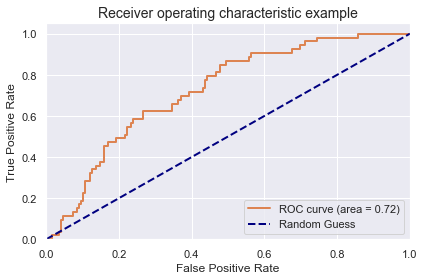

In [28]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(test_all[:], best_predictions_all[:])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='C1', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.tight_layout()

### The actual Parameter Optimisation and 5-fold CV code:

In [29]:
def CV_and_Parameter_Optimization(X_CV, y_CV, splits, Estimator, Estimator_parameters):
  splits=4
  start = time.time()
  # All 10 parameter optimisations and cross validations of a certain Classifier
  strat_kfold_external = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
  splitted_indexes_external = strat_kfold_external.split(X_CV, y_CV)
  params= [len(Estimator_parameters[param]) for param in Estimator_parameters]
  total_params= np.prod(params)
  best_index=[]
  AP_Score =np.array([])
  ROC_Score =np.array([])
  Prec_Score =np.array([])
  Recall_Score =np.array([])
  F1_Score =np.array([])
  Sens_Score =np.array([])
  Spec_Score =np.array([])
  Accuracy_Score =np.array([])

  best_predictions_all=np.array([])
  test_all=np.array([])
  i=1
  Sum=[0]*total_params

  for train_index_external, test_index_external in splitted_indexes_external:
      print("Parameter optimisation and CV number {} ... \t AUROC scores: {}".format(i, ROC_Score .round(3)))
      i=i+1
      # take i’th fold as test set and the other 3 folds together as training set
      X_train, X_test = X_CV.iloc[train_index_external], X_CV.iloc[test_index_external]
      y_train, y_test = y_CV.iloc[train_index_external], y_CV.iloc[test_index_external]    
      # take the training set and split it randomly (stratified) 
      # in an inner training set of 2/3 size and an inner validation set of 1/3 size

      # for each of the ML methods
      # for each combination of parameter values
      # train the ML method with specified parameters on inner training set and validate on inner validation set
      # take the combination of parameter values that yields highest performance (e.g. area under PR curve), 
      # also write down this parameter value combination train the ML method with best parameter values on
      # the (outer) training set and test on the (outer) test set

      mod=clone(Estimator)
      optimisation_param_AP = GridSearchCV(estimator=mod, param_grid=Estimator_parameters, cv=3, verbose=0, scoring='roc_auc')
      optimisation_param_AP.fit(X_train, y_train)
      best_index.append(optimisation_param_AP.best_index_+1)
      # Building Estimator with best parameters
      best= optimisation_param_AP.best_estimator_
      best.fit(X_train, y_train)
      best_predictions = best.predict_proba(X_test)[:,1]
      best_predictions=best_predictions
      Average_precision_score=average_precision_score(y_test, best_predictions)
      best_predictions_binary =  best.predict(X_test)
      t=confusion_matrix(y_test, best_predictions_binary)
      sensitivity=(t[1][1]/(t[1][0]+t[1][1]))
      specificity=(t[0][0]/(t[0][1]+t[0][0]))
      AP_Score =np.append(AP_Score , Average_precision_score)
      ROC_Score =np.append(ROC_Score , roc_auc_score(y_test, best_predictions))
      Prec_Score =np.append(Prec_Score , precision_score(y_test, best_predictions_binary))
      Recall_Score =np.append(Recall_Score , recall_score(y_test, best_predictions_binary))
      F1_Score =np.append(F1_Score , f1_score(y_test, best_predictions_binary))
      Sens_Score =np.append(Sens_Score , sensitivity)
      Spec_Score =np.append(Spec_Score , specificity)
      Accuracy_Score =np.append(Accuracy_Score , accuracy_score(y_test, best_predictions_binary))

      best_predictions_all=np.append(best_predictions_all,best_predictions)
      test_all=np.append(test_all,y_test)
      Sum=Sum+(optimisation_param_AP.cv_results_['mean_test_score']).round(2)

  print('Done! Validation AUROC score: \t\t\t{}'.format(ROC_Score .round(3)))
  end = time.time()
  total_time=round(end - start,1)
  print('Elapsed time: ', total_time,'seconds.' )
  print("\nParameter tested: ", Estimator_parameters)
  Avg=Sum/splits
  #print('Average of {} splits AUROC for all {} parameter sets:\n{}'.format(splits, total_params, Avg.round(4)))
  print('Best Average AUROC = {} for the {}th parameter set: {}'.format(round(Avg.max(),4), Avg.argmax()+1, optimisation_param_AP.cv_results_['params'][Avg.argmax()]))
  return AP_Score,  ROC_Score,  Prec_Score,  Recall_Score,  F1_Score,  Sens_Score, Spec_Score, Accuracy_Score,  best_predictions_all, test_all, total_time


And its output:

In [30]:
Estimator_parameters = {'C':[0.1, 0.5, 1, 10, 20] }
Estimator=LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')

LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all , LOGI_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, Estimator, Estimator_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.703]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.703 0.804]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.703 0.804 0.561]
Done! Validation AUROC score: 			[0.703 0.804 0.561 0.797]
Elapsed time:  0.8 seconds.

Parameter tested:  {'C': [0.1, 0.5, 1, 10, 20]}
Best Average AUROC = 0.705 for the 1th parameter set: {'C': 0.1}


In [31]:
d={} # dictionarry with all the results
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy', 'Time']
d['Logistic_mean'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean(), LOGI_time]
d['Logistic_std'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
df.round(2)

,Logistic_mean,Logistic_std
Average Precision,0.43,0.10
AUROC,0.72,0.10
Precision,0.39,0.11
Recall,0.62,0.17
F1_Score,0.48,0.13
Sensitivity,0.62,0.17
Specificity,0.69,0.09
Accuracy,0.68,0.10
Time,0.80,0.00


## 3.4 Model testing of KNN, Logistic Regression, Decision Tree Classifier, Random Forest, Gradient Boosting,  XGBoost, MLP and  Light-GBM for predicing Normal Baseline patients progressing to MCI/AD at last visit.

**3.3.1 KNN**

``` class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
 leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1, **kwargs)````

Tested parameters:

In [32]:
KNN_parameters = {'p':[1,2], 
                  'n_neighbors':[1, 3, 5, 9]}
KNN = KNeighborsClassifier(weights='distance')

In [33]:
# X_1 and y_1 are people with baseline normal Diagnosis
X_CV  = X_1 
y_CV  = y_1

# Scaling to a 0 to 1 scale
X_std = (X_CV - X_CV.min(axis=0)) / (X_CV.max(axis=0) - X_CV.min(axis=0))
X_CV  = X_std.dropna(axis=1).copy()

In [34]:
KNN_AP,  KNN_ROC,  KNN_Prec,  KNN_Recall,  KNN_F1,  KNN_Sens, KNN_Spec, \
KNN_Accuracy,  KNN_best_predictions_all,  KNN_test_all, KNN_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, KNN, KNN_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.492]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.492 0.469]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.492 0.469 0.509]
Done! Validation AUROC score: 			[0.492 0.469 0.509 0.42 ]
Elapsed time:  0.6 seconds.

Parameter tested:  {'p': [1, 2], 'n_neighbors': [1, 3, 5, 9]}
Best Average AUROC = 0.5725 for the 8th parameter set: {'n_neighbors': 9, 'p': 2}


In [35]:
d={} # dictionarry with all the results
d['1 KNN_mu'] = [KNN_AP.mean(),  KNN_ROC.mean(),  KNN_Prec.mean(),  KNN_Recall.mean(),  KNN_F1.mean(),  KNN_Sens.mean(), KNN_Spec.mean(), KNN_Accuracy.mean(), KNN_time]
d['1 KNN_std'] = [KNN_AP.std(),  KNN_ROC.std(),  KNN_Prec.std(),  KNN_Recall.std(),  KNN_F1.std(),  KNN_Sens.std(), KNN_Spec.std(), KNN_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu']].round(2)

**3.3.2 Logistic Regression**


```class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001,  C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None,  solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)```

Tested parameters: 

In [36]:
LOGI_parameters = {'C':[0.001,0.01,0.1,1,10,100,1000] }
LOGI =LogisticRegression(random_state=1,max_iter=1000,tol=5e-4, solver='liblinear', class_weight='balanced')

In [37]:
LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all, LOGI_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, LOGI, LOGI_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.68]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.68 0.78]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.68  0.78  0.589]
Done! Validation AUROC score: 			[0.68  0.78  0.589 0.762]
Elapsed time:  0.5 seconds.

Parameter tested:  {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Best Average AUROC = 0.7175 for the 4th parameter set: {'C': 1}


In [38]:
d['2 LOGI_mu'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean(), LOGI_time]
d['2 LOGI_std'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu']].round(2)

**3.3.3 SVM**


``` class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None) ```

Tested parameters: 

In [39]:
SVC_parameters = {'C':[0.00001, 0.0001, 0.001,0.1,1,10,100], 
                  'gamma':[0.0001, 0.001,0.1,1,10,100]}
svc=SVC(probability=True,random_state=1,class_weight='balanced', cache_size=20000,kernel='rbf')

In [40]:
SVC_AP,  SVC_ROC,  SVC_Prec,  SVC_Recall,  SVC_F1,  SVC_Sens, SVC_Spec, \
SVC_Accuracy,  SVC_best_predictions_all,  SVC_test_all, SVC_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, svc, SVC_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.661]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.661 0.841]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.661 0.841 0.605]
Done! Validation AUROC score: 			[0.661 0.841 0.605 0.802]
Elapsed time:  5.1 seconds.

Parameter tested:  {'C': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1, 10, 100]}
Best Average AUROC = 0.7425 for the 38th parameter set: {'C': 100, 'gamma': 0.001}


In [41]:
d['3 SVC_mu'] = [SVC_AP.mean(),  SVC_ROC.mean(),  SVC_Prec.mean(),  SVC_Recall.mean(),  SVC_F1.mean(),  SVC_Sens.mean(), SVC_Spec.mean(), SVC_Accuracy.mean(), SVC_time]
d['3 SVC_std'] = [SVC_AP.std(),  SVC_ROC.std(),  SVC_Prec.std(),  SVC_Recall.std(),  SVC_F1.std(),  SVC_Sens.std(), SVC_Spec.std(), SVC_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu']].round(2)

**3.3.4 Decision Tree**

```class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)```

Tested parameters: 

In [42]:
TREE_parameters ={ 'max_depth':range(2,15,2) }    
TREE = DecisionTreeClassifier(random_state=1)

In [43]:
TREE_AP,  TREE_ROC,  TREE_Prec,  TREE_Recall,  TREE_F1,  TREE_Sens, TREE_Spec, \
TREE_Accuracy,  TREE_best_predictions_all,  TREE_test_all, Tree_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, TREE, TREE_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.58]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.58  0.601]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.58  0.601 0.524]
Done! Validation AUROC score: 			[0.58  0.601 0.524 0.51 ]
Elapsed time:  0.5 seconds.

Parameter tested:  {'max_depth': range(2, 15, 2)}
Best Average AUROC = 0.5675 for the 1th parameter set: {'max_depth': 2}


In [44]:
d['4 TREE_mu'] = [TREE_AP.mean(),  TREE_ROC.mean(),  TREE_Prec.mean(),  TREE_Recall.mean(),  TREE_F1.mean(),  TREE_Sens.mean(), TREE_Spec.mean(), TREE_Accuracy.mean(), Tree_time]
d['4 TREE_std'] = [TREE_AP.std(),  TREE_ROC.std(),  TREE_Prec.std(),  TREE_Recall.std(),  TREE_F1.std(),  TREE_Sens.std(), TREE_Spec.std(), TREE_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu']].round(2)

#### 3.3.5 Random Forest

```class sklearn.ensemble.RandomForestClassifier(n_estimators=10->100, criterion='gini', 
max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)```

Tested parameters: 

In [45]:
RF_parameters = {'n_estimators':[50, 100, 500], 
                 'max_features':('sqrt', 'log2'), 
                 'min_samples_leaf':[1, 5]}
RF = RandomForestClassifier(random_state=1)

In [46]:
RF_AP,  RF_ROC,  RF_Prec,  RF_Recall,  RF_F1,  RF_Sens, RF_Spec, \
RF_Accuracy,  RF_best_predictions_all,  RF_test_all, RF_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, RF, RF_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.557]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.557 0.645]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.557 0.645 0.561]
Done! Validation AUROC score: 			[0.557 0.645 0.561 0.603]
Elapsed time:  25.4 seconds.

Parameter tested:  {'n_estimators': [50, 100, 500], 'max_features': ('sqrt', 'log2'), 'min_samples_leaf': [1, 5]}
Best Average AUROC = 0.625 for the 7th parameter set: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 50}


In [47]:
d['5 RF_mu'] = [RF_AP.mean(),  RF_ROC.mean(),  RF_Prec.mean(),  RF_Recall.mean(),  RF_F1.mean(),  RF_Sens.mean(), RF_Spec.mean(), RF_Accuracy.mean(), RF_time]
d['5 RF_std'] = [RF_AP.std(),  RF_ROC.std(),  RF_Prec.std(),  RF_Recall.std(),  RF_F1.std(),  RF_Sens.std(), RF_Spec.std(), RF_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu']].round(2)


#### 3.3.6 Gradient boosting
``` class sklearn.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
 max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')```

Tested parameters: 

In [48]:
BOOST_parameters = {'n_estimators':[50,100,500],
                    'max_leaf_nodes':[2,4,8,16],
                    'learning_rate':[1, 0.5, 0.1, 0.05, 0.01]}
BOOST=GradientBoostingClassifier(random_state=1)

In [49]:
BOOST_AP,  BOOST_ROC,  BOOST_Prec,  BOOST_Recall,  BOOST_F1,  BOOST_Sens, BOOST_Spec, \
BOOST_Accuracy,  BOOST_best_predictions_all,  BOOST_test_all, BOOST_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, BOOST, BOOST_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.62]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.62  0.691]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.62  0.691 0.565]
Done! Validation AUROC score: 			[0.62  0.691 0.565 0.702]
Elapsed time:  74.3 seconds.

Parameter tested:  {'n_estimators': [50, 100, 500], 'max_leaf_nodes': [2, 4, 8, 16], 'learning_rate': [1, 0.5, 0.1, 0.05, 0.01]}
Best Average AUROC = 0.665 for the 26th parameter set: {'learning_rate': 0.1, 'max_leaf_nodes': 2, 'n_estimators': 100}


In [50]:
d['6 BOOST_mu'] = [BOOST_AP.mean(),  BOOST_ROC.mean(),  BOOST_Prec.mean(),  BOOST_Recall.mean(),  BOOST_F1.mean(),  BOOST_Sens.mean(), BOOST_Spec.mean(), BOOST_Accuracy.mean(), BOOST_time]
d['6 BOOST_std'] = [BOOST_AP.std(),  BOOST_ROC.std(),  BOOST_Prec.std(),  BOOST_Recall.std(),  BOOST_F1.std(),  BOOST_Sens.std(), BOOST_Spec.std(), BOOST_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu']].round(2)

#### 3.3.7. XGBoost
 ``` class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)```

Bases: xgboost.sklearn.XGBModel, object
Implementation of the scikit-learn API for XGBoost classification.

Tested parameters: 

In [51]:
XGB2_parameters ={ 'max_depth':range(3,10,2),
                   'min_child_weight':range(1,3,2),
                   'gamma':[0, 0.1,0.2],
                   'subsample':[i/10.0 for i in range(6,9,2)],
                   'colsample_bytree':[i/10.0 for i in range(6,9,2)], 
                   'reg_alpha':[0, 0.005, 0.01, 0.05]}    
XGB2 = XGBClassifier(random_state=1)

In [52]:
XGB2_AP,  XGB2_ROC,  XGB2_Prec,  XGB2_Recall,  XGB2_F1,  XGB2_Sens, XGB2_Spec, \
XGB2_Accuracy,  XGB2_best_predictions_all,  XGB2_test_all, XGB2_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, XGB2, XGB2_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.537]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.537 0.766]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.537 0.766 0.584]
Done! Validation AUROC score: 			[0.537 0.766 0.584 0.584]
Elapsed time:  84.1 seconds.

Parameter tested:  {'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 3, 2), 'gamma': [0, 0.1, 0.2], 'subsample': [0.6, 0.8], 'colsample_bytree': [0.6, 0.8], 'reg_alpha': [0, 0.005, 0.01, 0.05]}
Best Average AUROC = 0.6425 for the 183th parameter set: {'colsample_bytree': 0.8, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'reg_alpha': 0.05, 'subsample': 0.6}


In [53]:
d['7 XGB2_mu'] = [XGB2_AP.mean(),  XGB2_ROC.mean(),  XGB2_Prec.mean(),  XGB2_Recall.mean(),  XGB2_F1.mean(),  XGB2_Sens.mean(), XGB2_Spec.mean(), XGB2_Accuracy.mean(), XGB2_time]
d['7 XGB2_std'] = [XGB2_AP.std(),  XGB2_ROC.std(),  XGB2_Prec.std(),  XGB2_Recall.std(),  XGB2_F1.std(),  XGB2_Sens.std(), XGB2_Spec.std(), XGB2_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu']].round(2)

#### 3.3.8 MLP

```class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)```

Tested parameters:

In [54]:
MLP_parameters = {'activation':('relu', 'logistic'), 
                  'hidden_layer_sizes':[(3, ),(20, ),(20,20 ),(50, ),(50,50 ),(100, )],
                  'alpha':[0.0001,0.001,0.09,0.1,0.5]}
MLP = MLPClassifier(random_state=1, max_iter=500,solver='adam')

In [55]:
MLP_AP,  MLP_ROC,  MLP_Prec,  MLP_Recall,  MLP_F1,  MLP_Sens, MLP_Spec, \
MLP_Accuracy,  MLP_best_predictions_all,  MLP_test_all , MLP_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, MLP, MLP_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.674]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.674 0.561]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.674 0.561 0.582]
Done! Validation AUROC score: 			[0.674 0.561 0.582 0.778]
Elapsed time:  142.2 seconds.

Parameter tested:  {'activation': ('relu', 'logistic'), 'hidden_layer_sizes': [(3,), (20,), (20, 20), (50,), (50, 50), (100,)], 'alpha': [0.0001, 0.001, 0.09, 0.1, 0.5]}
Best Average AUROC = 0.73 for the 60th parameter set: {'activation': 'logistic', 'alpha': 0.5, 'hidden_layer_sizes': (100,)}


In [56]:
d['8 MLP_mu'] = [MLP_AP.mean(),  MLP_ROC.mean(),  MLP_Prec.mean(),  MLP_Recall.mean(),  MLP_F1.mean(),  MLP_Sens.mean(), MLP_Spec.mean(), MLP_Accuracy.mean(), MLP_time]
d['8 MLP_std'] = [MLP_AP.std(),  MLP_ROC.std(),  MLP_Prec.std(),  MLP_Recall.std(),  MLP_F1.std(),  MLP_Sens.std(), MLP_Spec.std(), MLP_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu']].round(2)

#### 3.3.9 LGBM

```class lightgbm.Dataset(data, label=None, reference=None, weight=None, group=None, init_score=None, silent=False, feature_name='auto', categorical_feature='auto', params=None, free_raw_data=True)```

Test parameters:
- max_depth = 2, 3, 4, 5, 6, 7, 8, 9,10, 30
- n_estimators = 5, 25, 50

In [57]:
LGBM_params = {'max_depth' : [2,3,4,5,6,7,8,9,10, 30],
                'n_estimators': [5, 25, 50]}
lgbm=LGBMClassifier(random_state=1)

In [58]:
LGBM_AP,  LGBM_ROC,  LGBM_Prec,  LGBM_Recall,  LGBM_F1,  LGBM_Sens, LGBM_Spec, \
LGBM_Accuracy,  LGBM_best_predictions_all,  LGBM_test_all , LGBM_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, lgbm, LGBM_params)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.653]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.653 0.73 ]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.653 0.73  0.545]
Done! Validation AUROC score: 			[0.653 0.73  0.545 0.632]
Elapsed time:  14.7 seconds.

Parameter tested:  {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 30], 'n_estimators': [5, 25, 50]}
Best Average AUROC = 0.6475 for the 5th parameter set: {'max_depth': 3, 'n_estimators': 25}


In [59]:
d['9 LGBM_mu'] = [LGBM_AP.mean(),  LGBM_ROC.mean(),  LGBM_Prec.mean(),  LGBM_Recall.mean(),  LGBM_F1.mean(),  LGBM_Sens.mean(), LGBM_Spec.mean(), LGBM_Accuracy.mean(), LGBM_time]
d['9 LGBM_std'] = [LGBM_AP.std(),  LGBM_ROC.std(),  LGBM_Prec.std(),  LGBM_Recall.std(),  LGBM_F1.std(),  LGBM_Sens.std(), LGBM_Spec.std(), LGBM_Accuracy.std(), 0 ]
df = pd.DataFrame(data=d, index=Names)
df_normal_to_MCI_AD = df.copy()
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu', '9 LGBM_mu']].round(2)

### Results for predicting disease progression from Normal baseline to MCI/AD at last visit

In [60]:
df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu', '9 LGBM_mu']].round(2)

,1 KNN_mu,2 LOGI_mu,3 SVC_mu,4 TREE_mu,5 RF_mu,6 BOOST_mu,7 XGB2_mu,8 MLP_mu,9 LGBM_mu
Average Precision,0.24,0.43,0.47,0.27,0.35,0.35,0.36,0.39,0.38
AUROC,0.47,0.70,0.73,0.55,0.59,0.64,0.62,0.65,0.64
Precision,0.03,0.36,0.44,0.29,0.08,0.11,0.40,0.36,0.14
Recall,0.02,0.64,0.61,0.26,0.02,0.05,0.09,0.27,0.07
F1_Score,0.02,0.46,0.50,0.26,0.03,0.07,0.13,0.29,0.10
Sensitivity,0.02,0.64,0.61,0.26,0.02,0.05,0.09,0.27,0.07
Specificity,0.94,0.66,0.75,0.77,0.97,0.93,0.91,0.90,0.94
Accuracy,0.72,0.65,0.72,0.65,0.75,0.73,0.72,0.76,0.74
Time,0.60,0.50,5.10,0.50,25.40,74.30,84.10,142.20,14.70


**Plot of the AUROC curve for all the classifiers for predicting disease progression from Normal baseline to MCI/AD at last visit**

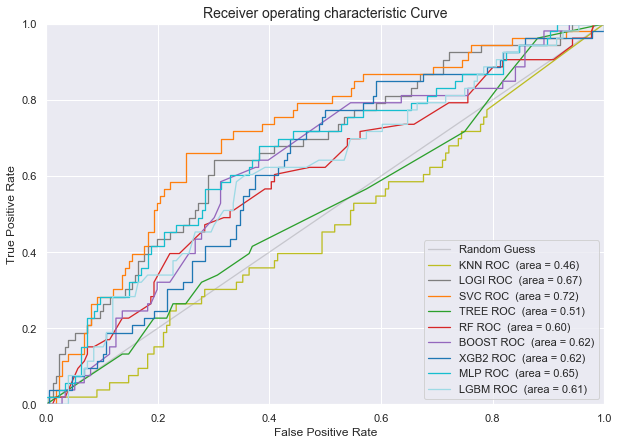

In [61]:
tableau20 = [ (188, 189, 34), (127, 127, 127),(255, 127, 14),(44, 160, 44),(214, 39, 40),  (148, 103, 189), 
             (31, 119, 180), (23, 190, 207), (158, 218, 229), (174, 199, 232), (247, 182, 210), 
             (127, 127, 127), (199, 199, 199), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.set_prop_cycle('color', tableau20)
lw = 1.3
plt.plot([0, 1], [0, 1], lw=lw, color='black', alpha=0.15, label='Random Guess')

# Compute ROC curve and ROC area for each class
ll= [ [KNN_test_all,KNN_best_predictions_all],
     [LOGI_test_all, LOGI_best_predictions_all],
     [SVC_test_all,SVC_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all]]
names=[ 'KNN', 'LOGI','SVC','TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  fpr = dict; tpr = dict; roc_auc = dict;
  fpr, tpr, _ = roc_curve(l[0][:], l[1][:]) # Calculating false positive rate and false negative rate
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=lw, label=names[i]+' ROC  (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

**Plot of the Precision-Recall curve for all the classifiers for predicting disease progression from Normal baseline to MCI/AD at last visit**

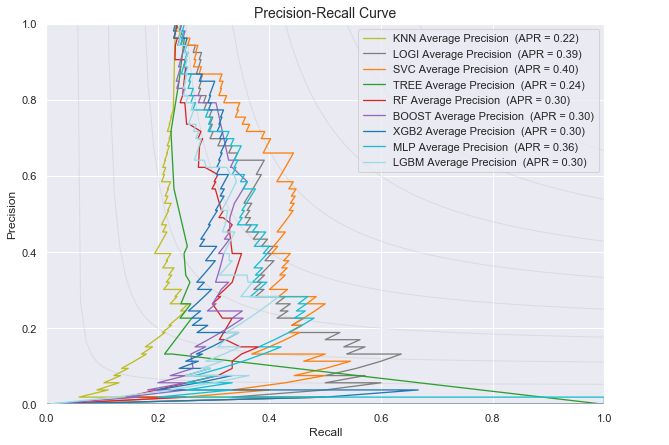

In [62]:
fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.set_prop_cycle('color', tableau20)
f_scores = np.linspace(0.1, 0.8, num=8)
lines = []
labels = []
lw = 1.3

for f_score in f_scores:
    x = np.linspace(0.001, 1, num=100)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.15, lw=1)
    plt.annotate('f1 = {0:0.1f}'.format(f_score), xy=(1.05, y[80] + 0.01), fontsize=9)

# Compute ROC curve and ROC area for each class
ll= [ [KNN_test_all,KNN_best_predictions_all],
     [LOGI_test_all, LOGI_best_predictions_all],
     [SVC_test_all,SVC_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all]]
names=[ 'KNN', 'LOGI','SVC','TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  precision = dict; recall = dict; average_precision = dict;
  precision, recall, _ = precision_recall_curve(l[0][:], l[1][:]) 
  average_precision = average_precision_score(l[0][:], l[1][:])
  plt.plot(precision, recall, lw=lw, label=names[i]+r' Average Precision  (APR = %0.2f)' % average_precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

**Barchart for all the classifiers for predicting disease progression from Normal baseline to MCI/AD at last visit**

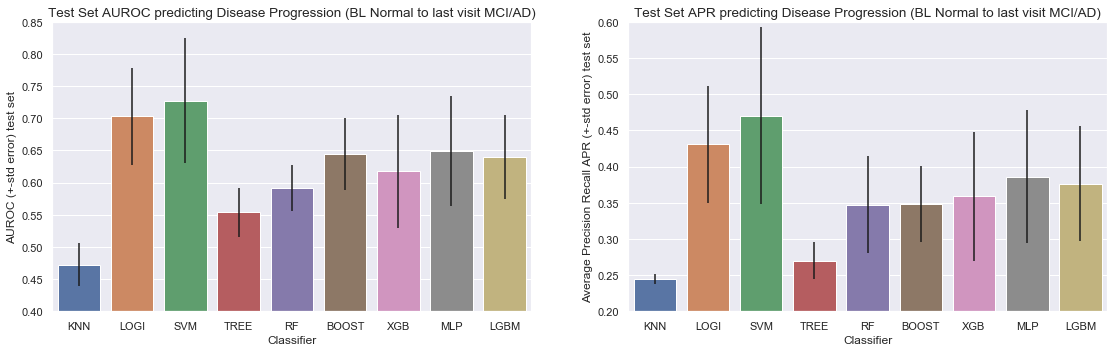

In [63]:
names=['KNN', 'LOGI', 'SVM', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
dataframe = pd.DataFrame({'Accuracy_mean':df.loc['AUROC'][0::2].values, 'Accuracy_std':df.loc['AUROC'][1::2].values}, index=names)
fig, ax= plt.subplots(1,2, figsize=(16,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[0], yerr=dataframe['Accuracy_std'].values)
ax[0].set_ylim((0.40, 0.85))
ax[0].set_title('Test Set AUROC predicting Disease Progression (BL Normal to last visit MCI/AD)', fontsize=13.5)
ax[0].set_ylabel('AUROC (+-std error) test set')
ax[0].set_xlabel('Classifier')
dataframe = pd.DataFrame({'Accuracy_mean':df.loc['Average Precision'][0::2].values, 'Accuracy_std':df.loc['Average Precision'][1::2].values}, index=names)
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[1], yerr=dataframe['Accuracy_std'].values)
ax[1].set_ylim((0.2, 0.6))
ax[1].set_title('Test Set APR predicting Disease Progression (BL Normal to last visit MCI/AD)', fontsize=13.5)
ax[1].set_xlabel('Classifier')
ax[1].set_ylabel('Average Precision Recall APR (+-std error) test set')
fig.tight_layout()

## 3.4 Model testing of KNN, Logistic Regression, Decision Tree Classifier, Random Forest, Gradient Boosting,  XGBoost, MLP and  Light-GBM for predicing MCI Baseline patients progressing to AD at last visit.

#### 3.4.1 KNN 

Tested parameters:

In [64]:
Names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy', 'Time']
# X_1 and y_1 are people with baseline normal Diagnosis
X_CV  = X_2
y_CV  = y_2

# Scaling to a 0 to 1 scale
X_std = (X_CV - X_CV.min(axis=0)) / (X_CV.max(axis=0) - X_CV.min(axis=0))
X_CV  = X_std.dropna(axis=1).copy()

In [65]:
KNN_parameters = {'p':[1,2], 'n_neighbors':[1, 3, 5, 9]}
KNN = KNeighborsClassifier(weights='distance')

In [66]:
KNN_AP,  KNN_ROC,  KNN_Prec,  KNN_Recall,  KNN_F1,  KNN_Sens, KNN_Spec, \
KNN_Accuracy,  KNN_best_predictions_all,  KNN_test_all, KNN_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, KNN, KNN_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.679]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.679 0.745]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.679 0.745 0.859]
Done! Validation AUROC score: 			[0.679 0.745 0.859 0.737]
Elapsed time:  0.8 seconds.

Parameter tested:  {'p': [1, 2], 'n_neighbors': [1, 3, 5, 9]}
Best Average AUROC = 0.7275 for the 8th parameter set: {'n_neighbors': 9, 'p': 2}


In [67]:
d={} # dictionarry with all the results
d['1 KNN_mu'] = [KNN_AP.mean(),  KNN_ROC.mean(),  KNN_Prec.mean(),  KNN_Recall.mean(),  KNN_F1.mean(),  KNN_Sens.mean(), KNN_Spec.mean(), KNN_Accuracy.mean(), KNN_time]
d['1 KNN_std'] = [KNN_AP.std(),  KNN_ROC.std(),  KNN_Prec.std(),  KNN_Recall.std(),  KNN_F1.std(),  KNN_Sens.std(), KNN_Spec.std(), KNN_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu']].round(2)

#### 3.4.2 Logistic Regression

Tested parameters: 

In [68]:
LOGI_parameters = {'C':[0.001,0.01,0.1,1,10,100,1000] }
LOGI =LogisticRegression(random_state=1,max_iter=1000,tol=5e-4, solver='liblinear', class_weight='balanced')

In [69]:
LOGI_AP,  LOGI_ROC,  LOGI_Prec,  LOGI_Recall,  LOGI_F1,  LOGI_Sens, LOGI_Spec, \
LOGI_Accuracy,  LOGI_best_predictions_all,  LOGI_test_all , LOGI_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, LOGI, LOGI_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.785]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.785 0.772]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.785 0.772 0.82 ]
Done! Validation AUROC score: 			[0.785 0.772 0.82  0.772]
Elapsed time:  0.5 seconds.

Parameter tested:  {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Best Average AUROC = 0.775 for the 4th parameter set: {'C': 1}


In [70]:
d['2 LOGI_mu'] = [LOGI_AP.mean(),  LOGI_ROC.mean(),  LOGI_Prec.mean(),  LOGI_Recall.mean(),  LOGI_F1.mean(),  LOGI_Sens.mean(), LOGI_Spec.mean(), LOGI_Accuracy.mean(), LOGI_time]
d['2 LOGI_std'] = [LOGI_AP.std(),  LOGI_ROC.std(),  LOGI_Prec.std(),  LOGI_Recall.std(),  LOGI_F1.std(),  LOGI_Sens.std(), LOGI_Spec.std(), LOGI_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu']].round(2)

#### 3.4.3 SVM

Tested parameters:

In [71]:
SVC_parameters = {'C':[0.1,1,10], 
                  'gamma':[0.01,0.1,1] }
svc=SVC(probability=True,random_state=1,class_weight='balanced', cache_size=20000,kernel='rbf')

In [72]:
SVC_AP,  SVC_ROC,  SVC_Prec,  SVC_Recall,  SVC_F1,  SVC_Sens, SVC_Spec, \
SVC_Accuracy,  SVC_best_predictions_all,  SVC_test_all, SVC_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, svc, SVC_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.766]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.766 0.759]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.766 0.759 0.83 ]
Done! Validation AUROC score: 			[0.766 0.759 0.83  0.758]
Elapsed time:  2.3 seconds.

Parameter tested:  {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
Best Average AUROC = 0.7725 for the 5th parameter set: {'C': 1, 'gamma': 0.1}


In [73]:
d['3 SVC_mu'] = [SVC_AP.mean(),  SVC_ROC.mean(),  SVC_Prec.mean(),  SVC_Recall.mean(),  SVC_F1.mean(),  SVC_Sens.mean(), SVC_Spec.mean(), SVC_Accuracy.mean(), SVC_time]
d['3 SVC_std'] = [SVC_AP.std(),  SVC_ROC.std(),  SVC_Prec.std(),  SVC_Recall.std(),  SVC_F1.std(),  SVC_Sens.std(), SVC_Spec.std(), SVC_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu']].round(2)

#### 3.4.4 Decision Tree

Tested parameters:

In [74]:
TREE_parameters ={ 'max_depth':range(2,15,2) }    
TREE = DecisionTreeClassifier(random_state=1)

In [75]:
TREE_AP,  TREE_ROC,  TREE_Prec,  TREE_Recall,  TREE_F1,  TREE_Sens, TREE_Spec, \
TREE_Accuracy,  TREE_best_predictions_all,  TREE_test_all, TREE_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, TREE, TREE_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.689]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.689 0.719]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.689 0.719 0.639]
Done! Validation AUROC score: 			[0.689 0.719 0.639 0.663]
Elapsed time:  0.5 seconds.

Parameter tested:  {'max_depth': range(2, 15, 2)}
Best Average AUROC = 0.645 for the 1th parameter set: {'max_depth': 2}


In [76]:
d['4 TREE_mu'] = [TREE_AP.mean(),  TREE_ROC.mean(),  TREE_Prec.mean(),  TREE_Recall.mean(),  TREE_F1.mean(),  TREE_Sens.mean(), TREE_Spec.mean(), TREE_Accuracy.mean(), TREE_time]
d['4 TREE_std'] = [TREE_AP.std(),  TREE_ROC.std(),  TREE_Prec.std(),  TREE_Recall.std(),  TREE_F1.std(),  TREE_Sens.std(), TREE_Spec.std(), TREE_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu']].round(2)

#### 3.4.5 Random Forest

Tested parameters:

In [77]:
RF_parameters = {'n_estimators':[50, 100, 500], 
                 'max_features':('sqrt', 'log2'), 
                 'min_samples_leaf':[1, 5]}
RF = RandomForestClassifier(random_state=1)

In [78]:
RF_AP,  RF_ROC,  RF_Prec,  RF_Recall,  RF_F1,  RF_Sens, RF_Spec, \
RF_Accuracy,  RF_best_predictions_all,  RF_test_all , RF_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, RF, RF_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.812]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.812 0.778]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.812 0.778 0.832]
Done! Validation AUROC score: 			[0.812 0.778 0.832 0.769]
Elapsed time:  30.5 seconds.

Parameter tested:  {'n_estimators': [50, 100, 500], 'max_features': ('sqrt', 'log2'), 'min_samples_leaf': [1, 5]}
Best Average AUROC = 0.78 for the 3th parameter set: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}


In [79]:
d['5 RF_mu'] = [RF_AP.mean(),  RF_ROC.mean(),  RF_Prec.mean(),  RF_Recall.mean(),  RF_F1.mean(),  RF_Sens.mean(), RF_Spec.mean(), RF_Accuracy.mean(), RF_time]
d['5 RF_std'] = [RF_AP.std(),  RF_ROC.std(),  RF_Prec.std(),  RF_Recall.std(),  RF_F1.std(),  RF_Sens.std(), RF_Spec.std(), RF_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu']].round(2)

#### 3.4.6 Gradient boosting
 
Tested parameters:

In [80]:
BOOST_parameters = {'n_estimators':[50,100,500],
                    'max_leaf_nodes':[2,4,8,16],
                    'learning_rate':[1, 0.5, 0.1, 0.05, 0.01]}
BOOST=GradientBoostingClassifier(random_state=1)

In [81]:
BOOST_AP,  BOOST_ROC,  BOOST_Prec,  BOOST_Recall,  BOOST_F1,  BOOST_Sens, BOOST_Spec, \
BOOST_Accuracy,  BOOST_best_predictions_all,  BOOST_test_all , BOOST_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, BOOST, BOOST_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.807]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.807 0.754]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.807 0.754 0.855]
Done! Validation AUROC score: 			[0.807 0.754 0.855 0.782]
Elapsed time:  96.0 seconds.

Parameter tested:  {'n_estimators': [50, 100, 500], 'max_leaf_nodes': [2, 4, 8, 16], 'learning_rate': [1, 0.5, 0.1, 0.05, 0.01]}
Best Average AUROC = 0.7825 for the 13th parameter set: {'learning_rate': 0.5, 'max_leaf_nodes': 2, 'n_estimators': 50}


In [82]:
d['6 BOOST_mu'] = [BOOST_AP.mean(),  BOOST_ROC.mean(),  BOOST_Prec.mean(),  BOOST_Recall.mean(),  BOOST_F1.mean(),  BOOST_Sens.mean(), BOOST_Spec.mean(), BOOST_Accuracy.mean(), BOOST_time]
d['6 BOOST_std'] = [BOOST_AP.std(),  BOOST_ROC.std(),  BOOST_Prec.std(),  BOOST_Recall.std(),  BOOST_F1.std(),  BOOST_Sens.std(), BOOST_Spec.std(), BOOST_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu']].round(2)

#### 3.4.7. XGBoost

Bases: xgboost.sklearn.XGBModel, object
Implementation of the scikit-learn API for XGBoost classification.

Tested parameters:

In [83]:
XGB2_parameters ={ 'max_depth':range(3,10,2),
                   'min_child_weight':range(1,3,2),
                   'gamma':[0, 0.1,0.2],
                   'subsample':[i/10.0 for i in range(6,9,2)],
                   'colsample_bytree':[i/10.0 for i in range(6,9,2)], 
                   'reg_alpha':[0, 0.005, 0.01, 0.05]}    
XGB2 = XGBClassifier(random_state=1)

In [84]:
XGB2_AP,  XGB2_ROC,  XGB2_Prec,  XGB2_Recall,  XGB2_F1,  XGB2_Sens, XGB2_Spec, \
XGB2_Accuracy,  XGB2_best_predictions_all,  XGB2_test_all , XGB2_time  \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, XGB2, XGB2_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.815]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.815 0.758]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.815 0.758 0.852]
Done! Validation AUROC score: 			[0.815 0.758 0.852 0.802]
Elapsed time:  126.9 seconds.

Parameter tested:  {'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 3, 2), 'gamma': [0, 0.1, 0.2], 'subsample': [0.6, 0.8], 'colsample_bytree': [0.6, 0.8], 'reg_alpha': [0, 0.005, 0.01, 0.05]}
Best Average AUROC = 0.7925 for the 135th parameter set: {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.05, 'subsample': 0.6}


In [85]:
d['7 XGB2_mu'] = [XGB2_AP.mean(),  XGB2_ROC.mean(),  XGB2_Prec.mean(),  XGB2_Recall.mean(),  XGB2_F1.mean(),  XGB2_Sens.mean(), XGB2_Spec.mean(), XGB2_Accuracy.mean(),XGB2_time ]
d['7 XGB2_std'] = [XGB2_AP.std(),  XGB2_ROC.std(),  XGB2_Prec.std(),  XGB2_Recall.std(),  XGB2_F1.std(),  XGB2_Sens.std(), XGB2_Spec.std(), XGB2_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu']].round(2)

#### 3.4.8 MLP

Tested parameters:

In [86]:
MLP_parameters = {'activation':('relu', 'logistic'), 
                  'hidden_layer_sizes':[(3, ),(20, ),(20,20 ),(50, ),(50,50 ),(100, )],
                  'alpha':[0.0001,0.001,0.09,0.1,0.5]}
MLP = MLPClassifier(random_state=1, max_iter=500,solver='adam')

In [87]:
MLP_AP,  MLP_ROC,  MLP_Prec,  MLP_Recall,  MLP_F1,  MLP_Sens, MLP_Spec, \
MLP_Accuracy,  MLP_best_predictions_all,  MLP_test_all , MLP_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, MLP, MLP_parameters)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.774]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.774 0.752]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.774 0.752 0.84 ]
Done! Validation AUROC score: 			[0.774 0.752 0.84  0.776]
Elapsed time:  136.9 seconds.

Parameter tested:  {'activation': ('relu', 'logistic'), 'hidden_layer_sizes': [(3,), (20,), (20, 20), (50,), (50, 50), (100,)], 'alpha': [0.0001, 0.001, 0.09, 0.1, 0.5]}
Best Average AUROC = 0.77 for the 12th parameter set: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}


In [88]:
d['8 MLP_mu'] = [MLP_AP.mean(),  MLP_ROC.mean(),  MLP_Prec.mean(),  MLP_Recall.mean(),  MLP_F1.mean(),  MLP_Sens.mean(), MLP_Spec.mean(), MLP_Accuracy.mean(), MLP_time]
d['8 MLP_std'] = [MLP_AP.std(),  MLP_ROC.std(),  MLP_Prec.std(),  MLP_Recall.std(),  MLP_F1.std(),  MLP_Sens.std(), MLP_Spec.std(), MLP_Accuracy.std() , 0]
df = pd.DataFrame(data=d, index=Names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu']].round(2)


#### 3.4.9 LGBM

Tested parameters:

In [89]:
LGBM_params = { 'max_depth' : [2,3,4,5,6,7,8,9,10, 30],
                'n_estimators': [5, 25, 50]}
lgbm=LGBMClassifier(random_state=1)

In [90]:
LGBM_AP,  LGBM_ROC,  LGBM_Prec,  LGBM_Recall,  LGBM_F1,  LGBM_Sens, LGBM_Spec, \
LGBM_Accuracy,  LGBM_best_predictions_all,  LGBM_test_all, LGBM_time \
= CV_and_Parameter_Optimization(X_CV, y_CV, splits, lgbm, LGBM_params)

Parameter optimisation and CV number 1 ... 	 AUROC scores: []
Parameter optimisation and CV number 2 ... 	 AUROC scores: [0.821]
Parameter optimisation and CV number 3 ... 	 AUROC scores: [0.821 0.771]
Parameter optimisation and CV number 4 ... 	 AUROC scores: [0.821 0.771 0.851]
Done! Validation AUROC score: 			[0.821 0.771 0.851 0.797]
Elapsed time:  19.8 seconds.

Parameter tested:  {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 30], 'n_estimators': [5, 25, 50]}
Best Average AUROC = 0.785 for the 3th parameter set: {'max_depth': 2, 'n_estimators': 50}


In [106]:
names=['Average Precision', 'AUROC', 'Precision', 'Recall', 'F1_Score', 'Sensitivity', 'Specificity', 'Accuracy', 'Time']
d['9 LGBM_mu'] = [LGBM_AP.mean(),  LGBM_ROC.mean(),  LGBM_Prec.mean(),  LGBM_Recall.mean(),  LGBM_F1.mean(),  LGBM_Sens.mean(), LGBM_Spec.mean(), LGBM_Accuracy.mean(), LGBM_time]
d['9 LGBM_std'] = [LGBM_AP.std(),  LGBM_ROC.std(),  LGBM_Prec.std(),  LGBM_Recall.std(),  LGBM_F1.std(),  LGBM_Sens.std(), LGBM_Spec.std(), LGBM_Accuracy.std(), 0]
df = pd.DataFrame(data=d, index=names)
#df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu', '9 LGBM_mu']].round(2)

### Results for predicting disease progression from MCI baseline to Alzheimers at last visit

In [107]:
df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu', '9 LGBM_mu']].round(2)

,1 KNN_mu,2 LOGI_mu,3 SVC_mu,4 TREE_mu,5 RF_mu,6 BOOST_mu,7 XGB2_mu,8 MLP_mu,9 LGBM_mu
Average Precision,0.69,0.77,0.75,0.60,0.78,0.78,0.80,0.77,0.81
AUROC,0.75,0.79,0.78,0.68,0.80,0.80,0.81,0.79,0.81
Precision,0.65,0.68,0.67,0.62,0.70,0.71,0.72,0.70,0.71
Recall,0.75,0.72,0.72,0.59,0.65,0.69,0.68,0.69,0.71
F1_Score,0.69,0.70,0.69,0.59,0.67,0.70,0.70,0.69,0.71
Sensitivity,0.75,0.72,0.72,0.59,0.65,0.69,0.68,0.69,0.71
Specificity,0.64,0.70,0.70,0.69,0.75,0.75,0.76,0.75,0.75
Accuracy,0.69,0.71,0.71,0.64,0.70,0.72,0.73,0.72,0.73
Time,0.80,0.50,2.30,0.50,30.50,96.00,126.90,136.90,19.80


**Plot of the AUROC curve for all the classifiers for predicting disease progression from MCI baseline to AD at last visit**

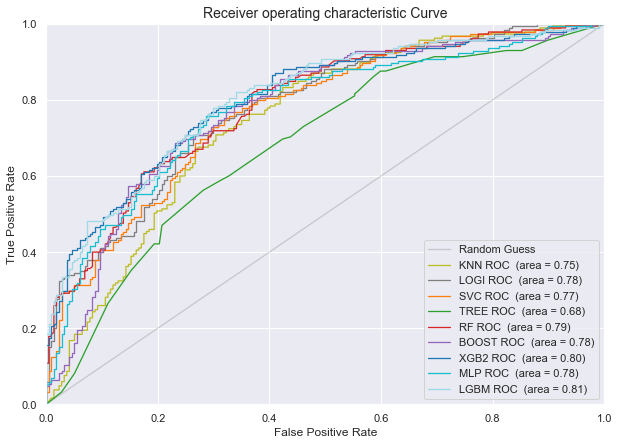

In [108]:
tableau20 = [ (188, 189, 34), (127, 127, 127),(255, 127, 14),(44, 160, 44),(214, 39, 40),  (148, 103, 189), 
             (31, 119, 180), (23, 190, 207), (158, 218, 229), (174, 199, 232), (247, 182, 210), 
             (127, 127, 127), (199, 199, 199), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.set_prop_cycle('color', tableau20)
lw = 1.3
plt.plot([0, 1], [0, 1], lw=lw, color='black', alpha=0.15, label='Random Guess')

# Compute ROC curve and ROC area for each class
ll= [ [KNN_test_all,KNN_best_predictions_all],
     [LOGI_test_all, LOGI_best_predictions_all],
     [SVC_test_all,SVC_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all]]
names=[ 'KNN', 'LOGI','SVC','TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  fpr = dict; tpr = dict; roc_auc = dict;
  fpr, tpr, _ = roc_curve(l[0][:], l[1][:]) # Calculating false positive rate and false negative rate
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=lw, label=names[i]+' ROC  (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

**Plot of the Precision-Recall curve for all the classifiers for predicting disease progression from MCI baseline to AD at last visit**

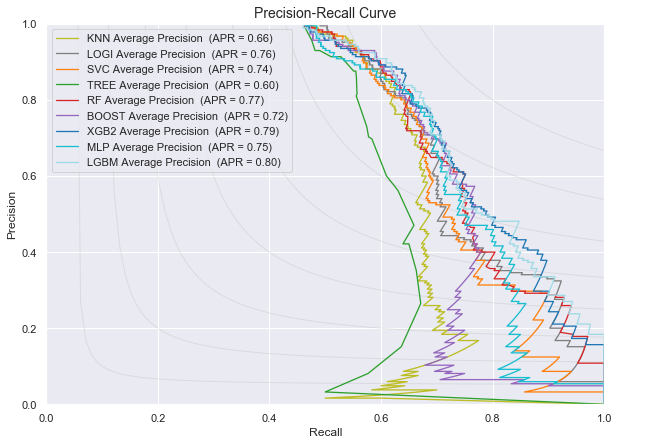

In [109]:
fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.set_prop_cycle('color', tableau20)
f_scores = np.linspace(0.1, 0.8, num=8)
lines = []
labels = []
lw = 1.3

for f_score in f_scores:
    x = np.linspace(0.001, 1, num=100)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.15, lw=1)
    plt.annotate('f1 = {0:0.1f}'.format(f_score), xy=(1.05, y[80] + 0.01), fontsize=9)

# Compute ROC curve and ROC area for each class
ll= [ [KNN_test_all,KNN_best_predictions_all],
     [LOGI_test_all, LOGI_best_predictions_all],
     [SVC_test_all,SVC_best_predictions_all],
     [TREE_test_all,TREE_best_predictions_all],
     [RF_test_all,RF_best_predictions_all],
     [BOOST_test_all,BOOST_best_predictions_all],
     [XGB2_test_all,XGB2_best_predictions_all],
     [MLP_test_all,MLP_best_predictions_all],
     [LGBM_test_all,LGBM_best_predictions_all]]
names=[ 'KNN', 'LOGI','SVC','TREE',  'RF',  'BOOST',  'XGB2',  'MLP',  'LGBM']
for i,l in enumerate(ll):
  precision = dict; recall = dict; average_precision = dict;
  precision, recall, _ = precision_recall_curve(l[0][:], l[1][:]) 
  average_precision = average_precision_score(l[0][:], l[1][:])
  plt.plot(precision, recall, lw=lw, label=names[i]+r' Average Precision  (APR = %0.2f)' % average_precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

**Barchart for all the classifiers for predicting disease progression from MCI baseline to AD at last visit**

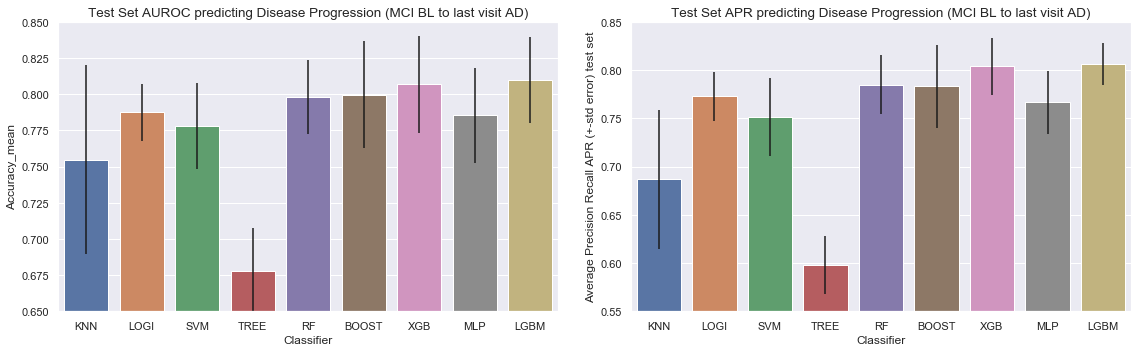

In [114]:
names=['KNN', 'LOGI', 'SVM', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
dataframe = pd.DataFrame({'Accuracy_mean':df.loc['AUROC'][0::2].values, 'Accuracy_std':df.loc['AUROC'][1::2].values}, index=names)
fig, ax= plt.subplots(1,2, figsize=(16,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[0], yerr=dataframe['Accuracy_std'].values)
ax[0].set_ylim((0.65, 0.85))
ax[0].set_title('Test Set AUROC predicting Disease Progression (MCI BL to last visit AD)', fontsize=13.5)
ax[0].set_ylabel('AUROC (+-std error) test set')
ax[0].set_xlabel('Classifier')
dataframe = pd.DataFrame({'Accuracy_mean':df.loc['Average Precision'][0::2].values, 'Accuracy_std':df.loc['Average Precision'][1::2].values}, index=names)
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[1], yerr=dataframe['Accuracy_std'].values)
ax[1].set_ylim((0.55, 0.85))
ax[1].set_title('Test Set APR predicting Disease Progression (MCI BL to last visit AD)', fontsize=13.5)
ax[1].set_xlabel('Classifier')
ax[1].set_ylabel('Average Precision Recall APR (+-std error) test set')
fig.tight_layout()

# 4 Summary

Two performance measurements were used specifically that allowed us to evaluate the predictive power of our models in a threshold-independent manner. 

**Conclusion for the models predicing progression from Normal at Baseline to Mild Cognitive Impairement or Alzheimer at the last visit:**

- **Area Under the Receiver Operating Curve (AUROC) score:** Logistic Regression and Support Vector Machines have by far the highest AUROC score. Although the Support Vector Machine Model showed the highest AUROC we do observe higher variation in results (a higher variation between the different AUROC scores of our 4-Cross Validation folds). The other advanced models (Gradiant Boosting, XGBoost, MLP and LGBM) showed simular performance, but inferior to logistic and SVC.
- **Average Precision Recall score:** Same observation here, logistic Regression and Support Vector Machines have the highest average precision and recall score.
- **Computational Time:** Gradient Boosting, XGBoost and MLP are the heaviest computationally.  LGBM proved to be very fast compared to the other tree-based models, while still having the same performance. It should be noted that the total time of the parameter optimization depends on the number of tested parameters and all the possible combinations. 

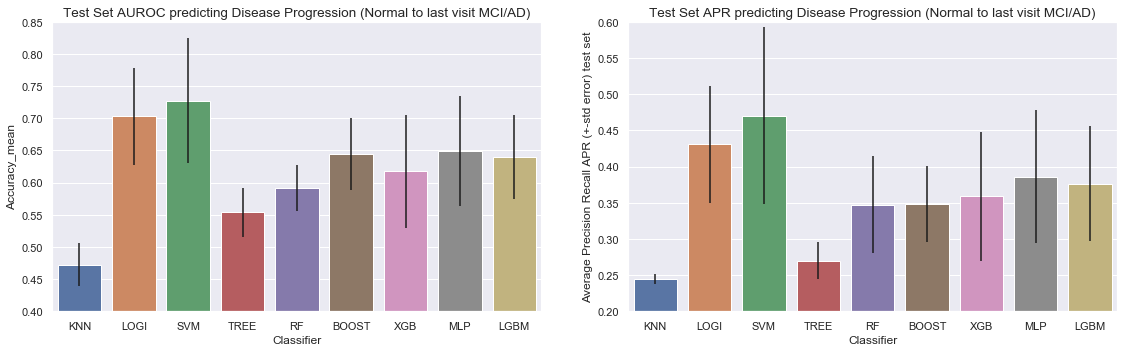

In [116]:
names=['KNN', 'LOGI', 'SVM', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
dataframe = pd.DataFrame({'Accuracy_mean':df_normal_to_MCI_AD.loc['AUROC'][0::2].values, 'Accuracy_std':df_normal_to_MCI_AD.loc['AUROC'][1::2].values}, index=names)
fig, ax= plt.subplots(1,2, figsize=(16,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[0], yerr=dataframe['Accuracy_std'].values)
ax[0].set_ylim((0.40, 0.85))
ax[0].set_title('Test Set AUROC predicting Disease Progression (Normal to last visit MCI/AD)', fontsize=13.5)
ax[0].set_ylabel('AUROC (+-std error) test set')
ax[0].set_xlabel('Classifier')
dataframe = pd.DataFrame({'Accuracy_mean':df_normal_to_MCI_AD.loc['Average Precision'][0::2].values, 'Accuracy_std':df_normal_to_MCI_AD.loc['Average Precision'][1::2].values}, index=names)
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[1], yerr=dataframe['Accuracy_std'].values)
ax[1].set_ylim((0.20, 0.6))
ax[1].set_title('Test Set APR predicting Disease Progression (Normal to last visit MCI/AD)', fontsize=13.5)
ax[1].set_xlabel('Classifier')
ax[1].set_ylabel('Average Precision Recall APR (+-std error) test set')
fig.tight_layout()

In [115]:
df_normal_to_MCI_AD[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu', '9 LGBM_mu']].round(2)

,1 KNN_mu,2 LOGI_mu,3 SVC_mu,4 TREE_mu,5 RF_mu,6 BOOST_mu,7 XGB2_mu,8 MLP_mu,9 LGBM_mu
Average Precision,0.24,0.43,0.47,0.27,0.35,0.35,0.36,0.39,0.38
AUROC,0.47,0.70,0.73,0.55,0.59,0.64,0.62,0.65,0.64
Precision,0.03,0.36,0.44,0.29,0.08,0.11,0.40,0.36,0.14
Recall,0.02,0.64,0.61,0.26,0.02,0.05,0.09,0.27,0.07
F1_Score,0.02,0.46,0.50,0.26,0.03,0.07,0.13,0.29,0.10
Sensitivity,0.02,0.64,0.61,0.26,0.02,0.05,0.09,0.27,0.07
Specificity,0.94,0.66,0.75,0.77,0.97,0.93,0.91,0.90,0.94
Accuracy,0.72,0.65,0.72,0.65,0.75,0.73,0.72,0.76,0.74
Time,0.60,0.50,5.10,0.50,25.40,74.30,84.10,142.20,14.70


**Conclusion for the models predicting progression from Mild Cognitive Impairement at baseline to Alzheimer at last visit:** LGBM and XGBoost have the highest AUROC and Average Precision Recall score, followed by random forest and gradient boosting and logistic regression. 

The AUROC in our models for patients evolving from normal to MCI/AD are lower compared to the AUROC for the models predicting which patient will evolve from MCI to AD. This might indicate it is harder to predict who will develop MCI or Alzheimer from normal baseline measurements. Yet once a patient suffers from Mild Cognitive Impairment already, our model can more easily predict if this patient will progress to Alzheimers Disease or not at the last visit. This observation might be explained by the multiple heterogeneous causes that may result in mild cognitive impaired, for example just the process of normal aging in general results in some degree of the loss of memory when people age. Further conclusion are hard to make concrete since we only have 400 individual patients to train our models on.

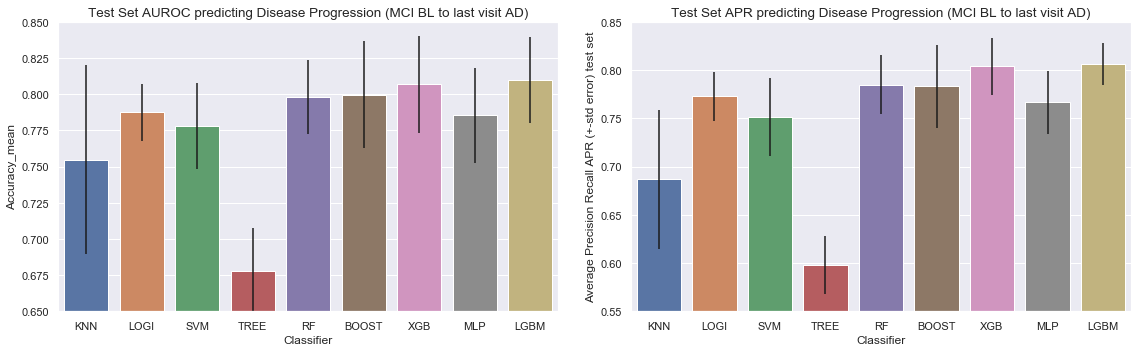

In [117]:
names=['KNN', 'LOGI', 'SVM', 'TREE','RF','BOOST', 'XGB', 'MLP', 'LGBM']
dataframe = pd.DataFrame({'Accuracy_mean':df.loc['AUROC'][0::2].values, 'Accuracy_std':df.loc['AUROC'][1::2].values}, index=names)
fig, ax= plt.subplots(1,2, figsize=(16,5))
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[0], yerr=dataframe['Accuracy_std'].values)
ax[0].set_ylim((0.65, 0.85))
ax[0].set_title('Test Set AUROC predicting Disease Progression (MCI BL to last visit AD)', fontsize=13.5)
ax[1].set_ylabel('AUROC (+-std error) test set')
ax[0].set_xlabel('Classifier')
dataframe = pd.DataFrame({'Accuracy_mean':df.loc['Average Precision'][0::2].values, 'Accuracy_std':df.loc['Average Precision'][1::2].values}, index=names)
sns.barplot(data=dataframe, x=dataframe.index.values, y=dataframe.Accuracy_mean, ax=ax[1], yerr=dataframe['Accuracy_std'].values)
ax[1].set_ylim((0.55, 0.85))
ax[1].set_title('Test Set APR predicting Disease Progression (MCI BL to last visit AD)', fontsize=13.5)
ax[1].set_xlabel('Classifier')
ax[1].set_ylabel('Average Precision Recall APR (+-std error) test set')
fig.tight_layout()

In [118]:
df[['1 KNN_mu', '2 LOGI_mu', '3 SVC_mu', '4 TREE_mu', '5 RF_mu',  '6 BOOST_mu', '7 XGB2_mu', '8 MLP_mu', '9 LGBM_mu']].round(2)

,1 KNN_mu,2 LOGI_mu,3 SVC_mu,4 TREE_mu,5 RF_mu,6 BOOST_mu,7 XGB2_mu,8 MLP_mu,9 LGBM_mu
Average Precision,0.69,0.77,0.75,0.60,0.78,0.78,0.80,0.77,0.81
AUROC,0.75,0.79,0.78,0.68,0.80,0.80,0.81,0.79,0.81
Precision,0.65,0.68,0.67,0.62,0.70,0.71,0.72,0.70,0.71
Recall,0.75,0.72,0.72,0.59,0.65,0.69,0.68,0.69,0.71
F1_Score,0.69,0.70,0.69,0.59,0.67,0.70,0.70,0.69,0.71
Sensitivity,0.75,0.72,0.72,0.59,0.65,0.69,0.68,0.69,0.71
Specificity,0.64,0.70,0.70,0.69,0.75,0.75,0.76,0.75,0.75
Accuracy,0.69,0.71,0.71,0.64,0.70,0.72,0.73,0.72,0.73
Time,0.80,0.50,2.30,0.50,30.50,96.00,126.90,136.90,19.80
